In [1]:
# import os

# # Set the environment variable for SeisBench cache root
# os.environ['SEISBENCH_CACHE_ROOT'] = '/cs/student/projects1/dsml/2023/jingfagu/SCEDC/.seisbench'

# # Verify the environment variable
# print(f"SEISBENCH_CACHE_ROOT is set to: {os.environ.get('SEISBENCH_CACHE_ROOT')}")

# # Create the cache directory if it doesn't exist
# cache_dir = os.environ['SEISBENCH_CACHE_ROOT']
# os.makedirs(cache_dir, exist_ok=True)

# # Now import and use SeisBench
# import seisbench
# import seisbench.data as sbd

# # Verify that SeisBench is using the correct cache root
# print(f"SeisBench cache root: {seisbench.cache_root}")

# # Load a dataset
# scedc = sbd.SCEDC(force=True)
# print(f"Dataset path: {scedc.path}")

# # List the contents of the cache directory
# print(f"Contents of cache directory:")
# print(os.listdir(cache_dir))

# # Check if the SCEDC dataset directory exists
# scedc_dir = os.path.join(cache_dir, 'datasets', 'scedc')
# if os.path.exists(scedc_dir):
#     print(f"SCEDC directory exists at: {scedc_dir}")
#     print(f"Contents of SCEDC directory:")
#     print(os.listdir(scedc_dir))
# else:
#     print(f"SCEDC directory not found at: {scedc_dir}")

In [2]:
# !pip install seisbench
# from google.colab import drive
# import os
# import seisbench.data as sbd

# # Mount Google Drive
# drive.mount('/content/drive')

# # Set the SeisBench cache root to a folder in your Google Drive
# os.environ['SEISBENCH_CACHE_ROOT'] = '/content/drive/MyDrive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/Datasets/INSTANCE/seisbench_cache/.seisbench'

# # Print the new cache root to verify
# print(f"SeisBench cache root: {os.environ['SEISBENCH_CACHE_ROOT']}")

# # Load the INSTANCE dataset
# instance = sbd.InstanceCounts()

# # Print information about the cached data
# print(f"INSTANCE dataset path: {instance.path}")
# print(f"Files in INSTANCE dataset folder:")
# print(os.listdir(instance.path))


In [ ]:
!pip install seisbench
from google.colab import drive
import os
import seisbench.data as sbd

# Mount Google Drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import torch
from obspy.clients.fdsn import Client
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ast

In [ ]:
# Load and access the metadata from the CSV file
metadata_path = "/content/drive/My Drive/INSTANCE_Dataset/metadata.csv"
metadata = pd.read_csv(metadata_path, low_memory=False)
print(f"Initial number of metadata entries: {len(metadata)}")

Initial number of metadata entries: 1159249


In [ ]:
import seisbench
import seisbench.data as sbd
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import os
import time
import scipy.signal
from tqdm import tqdm
from datetime import datetime, timezone
import shutil

In [ ]:
# Ensure the 'source_origin_time' column is in datetime format
metadata['source_origin_time'] = pd.to_datetime(metadata['source_origin_time'])

# Sort by source_origin_time to ensure chronological order
metadata = metadata.sort_values(by='source_origin_time')

# Filter metadata for dates from September 2018 onwards
start_date = datetime(2018, 9, 1, tzinfo=timezone.utc)
metadata = metadata[metadata['source_origin_time'] >= start_date]

print(f"Number of metadata entries from 1st September 2018 to 31st January 2020: {len(metadata)}")

Number of metadata entries from 1st September 2018 to 31st January 2020: 108398


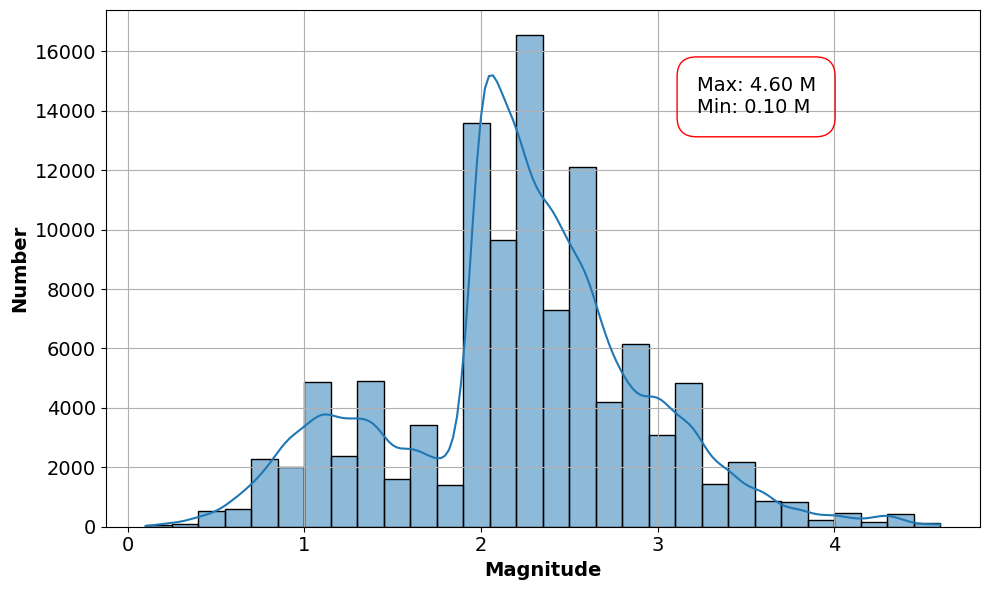

In [ ]:
# Plot the histogram of the earthquake magnitudes before filtering
plt.figure(figsize=(10, 6))
sns.histplot(metadata["source_magnitude"], bins=30, kde=True)
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_magnitude = metadata["source_magnitude"].max()
min_magnitude = metadata["source_magnitude"].min()
plt.text(0.7*max_magnitude, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_magnitude:.2f} M\nMin: {min_magnitude:.2f} M',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Number of metadata entries now: {len(metadata)}")

Number of metadata entries now: 108398


In [ ]:
metadata['trace_sampling_rate_hz'] = 100

In [ ]:
if 'trace_sampling_rate_hz' in metadata.columns:
    print("trace_sampling_rate_hz is present")
else:
    print("trace_sampling_rate_hz is not present")

trace_sampling_rate_hz is present


In [ ]:
import copy

# Create a deep copy of the metadata
filtered_metadata = copy.deepcopy(metadata)

In [ ]:
# Adjusted filtering for INSTANCE dataset with 30s window
filters = [
    ('path_ep_distance_km <= 110', filtered_metadata.path_ep_distance_km <= 110),
    ('source_magnitude_type == ML', filtered_metadata.source_magnitude_type == 'ML'),
    ('trace_P_arrival_sample.notnull()', filtered_metadata.trace_P_arrival_sample.notnull()),
    ('path_travel_time_P_s.notnull()', filtered_metadata.path_travel_time_P_s.notnull()),
    ('path_travel_time_P_s > 0', filtered_metadata.path_travel_time_P_s > 0),
    ('path_ep_distance_km.notnull()', filtered_metadata.path_ep_distance_km.notnull()),
    ('path_ep_distance_km > 0', filtered_metadata.path_ep_distance_km > 0),
    ('source_depth_km.notnull()', filtered_metadata.source_depth_km.notnull()),
    ('source_magnitude.notnull()', filtered_metadata.source_magnitude.notnull()),
    ('path_backazimuth_deg.notnull()', filtered_metadata.path_backazimuth_deg.notnull()),
    ('path_backazimuth_deg > 0', filtered_metadata.path_backazimuth_deg > 0),
]

# Apply filters one by one and keep track of the data
for desc, filt in filters:
    filtered_metadata = filtered_metadata[filt]
    print(f"After filter '{desc}': {len(filtered_metadata)} entries")

# Print P-arrival statistics before applying time window constraints
print("\nP arrival sample distribution before time window filtering:")
print(filtered_metadata.trace_P_arrival_sample.describe())

# Ensure at least 30 seconds of data after P-arrival
filtered_metadata = filtered_metadata[filtered_metadata.trace_P_arrival_sample + filtered_metadata.trace_sampling_rate_hz * 30 <= filtered_metadata.trace_npts]
print(f"After ensuring 30s after P arrival: {len(filtered_metadata)} entries")

# Calculate time window statistics
filtered_metadata['window_start'] = filtered_metadata.trace_P_arrival_sample - filtered_metadata.trace_sampling_rate_hz * 5  # 5 seconds before P arrival
filtered_metadata['window_end'] = filtered_metadata.trace_P_arrival_sample + filtered_metadata.trace_sampling_rate_hz * 25  # 25 seconds after P arrival (total 30s window)

# Ensure window start is not negative
filtered_metadata = filtered_metadata[filtered_metadata.window_start >= 0]
print(f"After ensuring non-negative window start: {len(filtered_metadata)} entries")

print(f"\nFinal number of filtered metadata entries: {len(filtered_metadata)}")

# Display some statistics about the filtered dataset
print("\nFiltered Dataset Statistics:")
print(f"Magnitude range: {filtered_metadata.source_magnitude.min()} - {filtered_metadata.source_magnitude.max()}")
print(f"Depth range: {filtered_metadata.source_depth_km.min()} - {filtered_metadata.source_depth_km.max()} km")
print(f"Distance range: {filtered_metadata.path_ep_distance_km.min()} - {filtered_metadata.path_ep_distance_km.max()} km")

# Additional statistics
print("\nMagnitude distribution:")
print(filtered_metadata.source_magnitude.describe())

print("\nDepth distribution:")
print(filtered_metadata.source_depth_km.describe())

print("\nP arrival sample distribution:")
print(filtered_metadata.trace_P_arrival_sample.describe())

# Check for S arrivals in the filtered dataset
s_arrivals = filtered_metadata[filtered_metadata.trace_S_arrival_sample.notnull()]
print(f"\nNumber of entries with S arrivals: {len(s_arrivals)}")
if len(s_arrivals) > 0:
    print("\nS arrival sample distribution:")
    print(s_arrivals.trace_S_arrival_sample.describe())

print("\nWindow start sample distribution:")
print(filtered_metadata.window_start.describe())

print("\nWindow end sample distribution:")
print(filtered_metadata.window_end.describe())

# Check if all windows are within the trace
valid_windows = (filtered_metadata.window_start >= 0) & (filtered_metadata.window_end <= filtered_metadata.trace_npts)
print(f"\nNumber of entries with valid 30s windows: {valid_windows.sum()}")

# Verify that the original metadata is unchanged
print(f"\nOriginal number of metadata entries: {len(metadata)}")

After filter 'path_ep_distance_km <= 110': 90264 entries
After filter 'source_magnitude_type == ML': 88501 entries
After filter 'trace_P_arrival_sample.notnull()': 88501 entries
After filter 'path_travel_time_P_s.notnull()': 88501 entries


<ipython-input-13-d78c308209ad>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]
<ipython-input-13-d78c308209ad>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]
<ipython-input-13-d78c308209ad>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]
<ipython-input-13-d78c308209ad>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'path_travel_time_P_s > 0': 88501 entries
After filter 'path_ep_distance_km.notnull()': 88501 entries
After filter 'path_ep_distance_km > 0': 88501 entries
After filter 'source_depth_km.notnull()': 88501 entries


<ipython-input-13-d78c308209ad>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]
<ipython-input-13-d78c308209ad>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]
<ipython-input-13-d78c308209ad>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]
<ipython-input-13-d78c308209ad>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After filter 'source_magnitude.notnull()': 88501 entries
After filter 'path_backazimuth_deg.notnull()': 88501 entries
After filter 'path_backazimuth_deg > 0': 88494 entries

P arrival sample distribution before time window filtering:
count    88494.000000
mean      1847.211133
std        177.339336
min       1171.000000
25%       1712.000000
50%       1846.000000
75%       1971.000000
max       6415.000000
Name: trace_P_arrival_sample, dtype: float64
After ensuring 30s after P arrival: 88494 entries


<ipython-input-13-d78c308209ad>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]
<ipython-input-13-d78c308209ad>:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_metadata = filtered_metadata[filt]


After ensuring non-negative window start: 88494 entries

Final number of filtered metadata entries: 88494

Filtered Dataset Statistics:
Magnitude range: 0.1 - 4.3
Depth range: 0.1 - 441.9 km
Distance range: 0.224 - 109.996 km

Magnitude distribution:
count    88494.000000
mean         2.066323
std          0.634838
min          0.100000
25%          1.700000
50%          2.100000
75%          2.500000
max          4.300000
Name: source_magnitude, dtype: float64

Depth distribution:
count    88494.000000
mean        20.313827
std         38.611067
min          0.100000
25%          8.800000
50%         10.300000
75%         14.300000
max        441.900000
Name: source_depth_km, dtype: float64

P arrival sample distribution:
count    88494.000000
mean      1847.211133
std        177.339336
min       1171.000000
25%       1712.000000
50%       1846.000000
75%       1971.000000
max       6415.000000
Name: trace_P_arrival_sample, dtype: float64

Number of entries with S arrivals: 59163

S a

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import torch
import scipy.signal

In [ ]:
# Apply SNR filter
def string_convertor(dd):
    if isinstance(dd, str):
        dd2 = dd.split()
        SNR = []
        for d in dd2:
            if d not in ['[', ']']:
                dL = d.split('[')
                dR = d.split(']')
                if len(dL) == 2:
                    dig = dL[1]
                elif len(dR) == 2:
                    dig = dR[0]
                elif len(dR) == 1 and len(dL) == 1:
                    dig = d
                try:
                    dig = float(dig)
                except Exception:
                    dig = None
                SNR.append(dig)
        return np.mean([x for x in SNR if x is not None])
    else:
        return np.nan

In [ ]:
if 'snr_db' in metadata.columns:
    print("snr_db is present")
else:
    print("snr_db is not present")

snr_db is not present


In [ ]:
# Check if 'snr_db' column exists, if not, use appropriate column names from INSTANCE dataset
if 'snr_db' in filtered_metadata.columns:
    filtered_metadata['snr_db'] = filtered_metadata.snr_db.apply(string_convertor)
    filtered_metadata = filtered_metadata[filtered_metadata.snr_db >= 20]
else:
    # Use appropriate SNR columns from INSTANCE dataset
    snr_columns = ['trace_E_snr_db', 'trace_N_snr_db', 'trace_Z_snr_db']
    filtered_metadata['avg_snr_db'] = filtered_metadata[snr_columns].mean(axis=1)
    filtered_metadata = filtered_metadata[filtered_metadata.avg_snr_db >= 20]

print(f"Number of records after SNR filtering: {len(filtered_metadata)}")

Number of records after SNR filtering: 28149


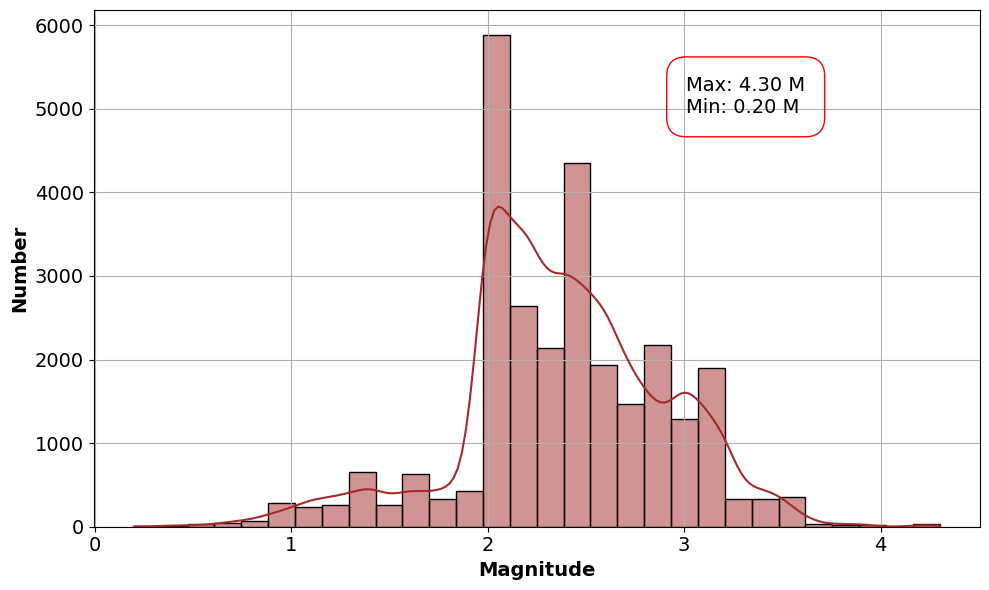

In [ ]:
# Plot the histogram of the earthquake magnitudes after filtering
plt.figure(figsize=(10, 6))
sns.histplot(filtered_metadata["source_magnitude"], bins=30, kde=True, color='brown')
plt.xlabel('Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
max_magnitude = filtered_metadata["source_magnitude"].max()
min_magnitude = filtered_metadata["source_magnitude"].min()
plt.text(0.7*max_magnitude, plt.gca().get_ylim()[1]*0.8,
         f'Max: {max_magnitude:.2f} M\nMin: {min_magnitude:.2f} M',
         bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=1'), fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import h5py

def explore_hdf5_structure(file_path):
    def print_structure(name, obj):
        print(name)
        if isinstance(obj, h5py.Group):
            print(f"  Group: {list(obj.keys())}")
        elif isinstance(obj, h5py.Dataset):
            print(f"  Dataset: shape={obj.shape}, dtype={obj.dtype}")

    with h5py.File(file_path, 'r') as f:
        f.visititems(print_structure)

# Use this function to explore the structure
hdf5_path = "/content/drive/My Drive/INSTANCE_Dataset/waveforms.hdf5"
explore_hdf5_structure(hdf5_path)

data
  Group: ['bucket0', 'bucket1', 'bucket10', 'bucket100', 'bucket1000', 'bucket1001', 'bucket1002', 'bucket1003', 'bucket1004', 'bucket1005', 'bucket1006', 'bucket1007', 'bucket1008', 'bucket1009', 'bucket101', 'bucket1010', 'bucket1011', 'bucket1012', 'bucket1013', 'bucket1014', 'bucket1015', 'bucket1016', 'bucket1017', 'bucket1018', 'bucket1019', 'bucket102', 'bucket1020', 'bucket1021', 'bucket1022', 'bucket1023', 'bucket1024', 'bucket1025', 'bucket1026', 'bucket1027', 'bucket1028', 'bucket1029', 'bucket103', 'bucket1030', 'bucket1031', 'bucket1032', 'bucket1033', 'bucket1034', 'bucket1035', 'bucket1036', 'bucket1037', 'bucket1038', 'bucket1039', 'bucket104', 'bucket1040', 'bucket1041', 'bucket1042', 'bucket1043', 'bucket1044', 'bucket1045', 'bucket1046', 'bucket1047', 'bucket1048', 'bucket1049', 'bucket105', 'bucket1050', 'bucket1051', 'bucket1052', 'bucket1053', 'bucket1054', 'bucket1055', 'bucket1056', 'bucket1057', 'bucket1058', 'bucket1059', 'bucket106', 'bucket1060', 'bucke

In [ ]:
def load_data(instance_dataset, metadata):
    X = []
    Y = []
    log_stream_max = []

    hdf5_path = "/content/drive/My Drive/INSTANCE_Dataset/waveforms.hdf5"

    with h5py.File(hdf5_path, 'r') as hdf:
        for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
            try:
                trace_name = row['trace_name']
                sampling_rate = row['trace_sampling_rate_hz']

                # Parse the trace name
                bucket, trace_info = trace_name.split('$')
                trace_index = int(trace_info.split(',')[0])

                # Retrieve waveform data
                waveform = np.array(hdf['data'][bucket][trace_index])

                print(f"Processing {trace_name}")
                print(f"Waveform shape: {waveform.shape}")

                spt = int(row['trace_P_arrival_sample'])
                print(f"P arrival sample: {spt}")

                # Adjust window size based on sampling rate
                window_samples = int(30 * sampling_rate)  # 30 seconds window
                start = max(0, spt - int(5 * sampling_rate))  # 5 seconds before P arrival
                end = start + window_samples

                print(f"Window: start={start}, end={end}, window_samples={window_samples}")

                if start >= waveform.shape[1] or end > waveform.shape[1]:
                    print(f"Skipping event {trace_name}: Invalid window")
                    continue

                dshort = waveform[:, start:end]
                print(f"Windowed waveform shape: {dshort.shape}")

                # Ensure the shape is correct
                if dshort.shape[1] != window_samples:
                    print(f"Skipping event {trace_name}: Incorrect window size")
                    continue

                # Resample to 100 Hz if necessary
                if sampling_rate != 100:
                    dshort = scipy.signal.resample(dshort, (3, 3000), axis=1)

                X.append(dshort)
                Y.append(round(float(row['source_magnitude']), 2))

                # Extract log_stream_max
                max_values = np.max(np.abs(dshort), axis=1)
                log_max_values = np.log10(max_values + 1e-10)
                log_stream_max.append(log_max_values)

            except Exception as e:
                print(f"Error processing event {trace_name}: {e}")
                continue

    X = np.array(X)
    Y = np.array(Y)
    log_stream_max = np.array(log_stream_max)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), torch.tensor(log_stream_max, dtype=torch.float32)

In [ ]:
import h5py

# Load and preprocess data
data, labels, log_stream_max = load_data(hdf5_path, filtered_metadata)

In [ ]:
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Log stream max shape: {log_stream_max.shape}")

Data shape: torch.Size([28149, 3, 3000])
Labels shape: torch.Size([28149])
Log stream max shape: torch.Size([28149, 3])


In [ ]:
# # Save preprocessed data to Google Drive
# output_data_file = "/content/drive/MyDrive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/Datasets/INSTANCE/INSTANCE_pre_processed_data.npy"
# output_labels_file = "/content/drive/MyDrive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/Datasets/INSTANCE/INSTANCE_pre_processed_labels.npy"
# output_log_stream_max_file = "/content/drive/MyDrive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/Datasets/INSTANCE/INSTANCE_log_stream_max.npy"

# np.save(output_data_file, data.numpy())
# np.save(output_labels_file, labels.numpy())
# np.save(output_log_stream_max_file, log_stream_max.numpy())

# print(f"Preprocessed data saved to {output_data_file}")
# print(f"Preprocessed labels saved to {output_labels_file}")
# print(f"Log stream max values saved to {output_log_stream_max_file}")



In [ ]:
print("Job done!!!")

Job done!!!


# Recalculate max_values

In [ ]:
# Recalculate max_values
max_values = 10**(np.array(log_stream_max)) - 1e-10

# Ensure the shape matches log_stream_max
assert max_values.shape == log_stream_max.shape, "Shapes do not match!"

# Print the shape to confirm
print("Recovered max_values shape:", max_values.shape)

Recovered max_values shape: (28149, 3)


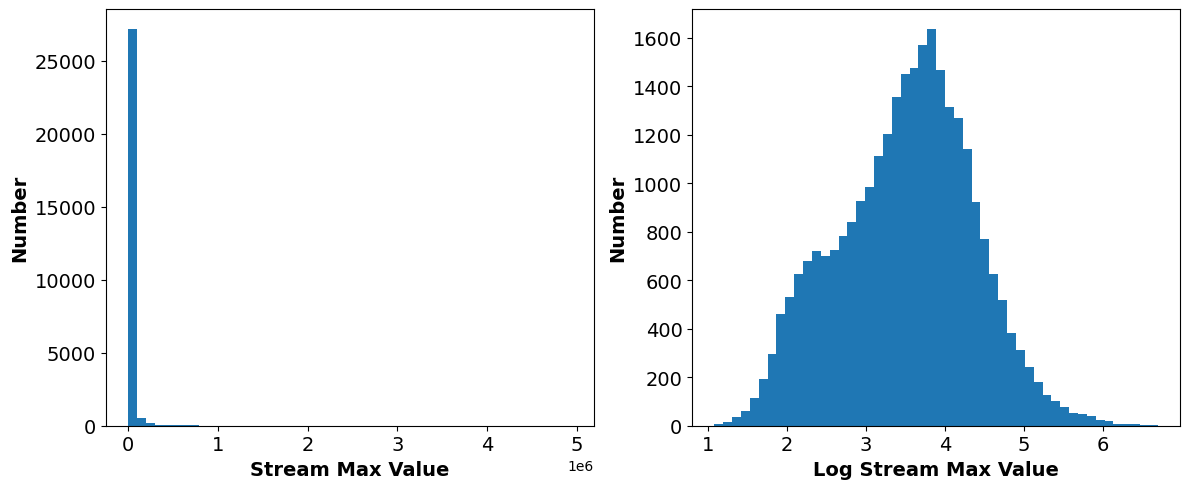

In [ ]:
import time
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import h5py

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import time



# Plot histograms of max values and log max values for the vertical component
vertical_index = 0

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(max_values[:, vertical_index], bins=50)  # No need for .numpy() here
plt.xlabel('Stream Max Value', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(1, 2, 2)
plt.hist(log_stream_max[:, vertical_index], bins=50)  # No need for .numpy() here
plt.xlabel('Log Stream Max Value', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

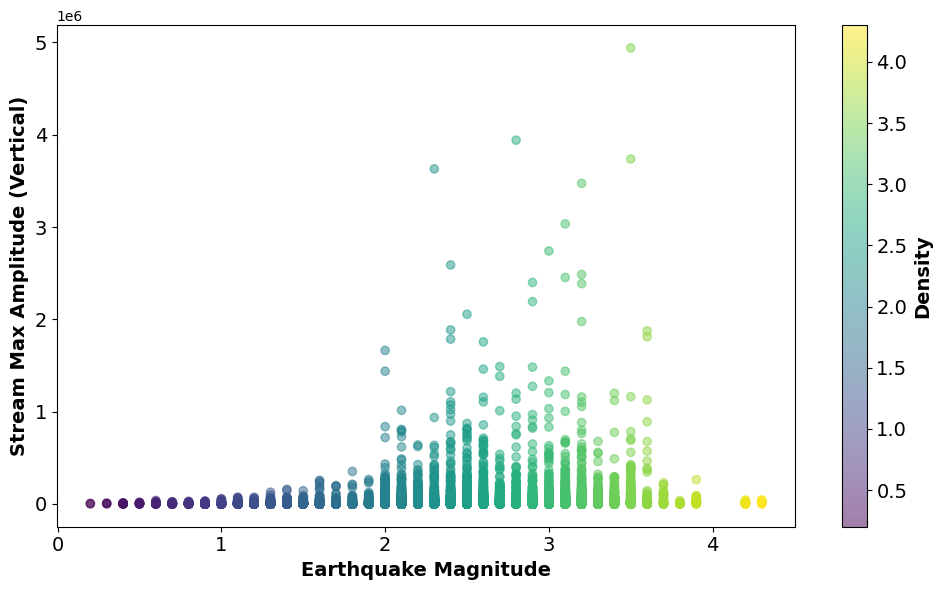

In [ ]:
# Scatter plot of max values vs. labels for the vertical component
plt.figure(figsize=(10, 6))
scatter = plt.scatter(labels.numpy(), max_values[:, vertical_index], alpha=0.5, c=labels.numpy(), cmap='viridis')
plt.xlabel('Earthquake Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Stream Max Amplitude (Vertical)', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
cbar = plt.colorbar(scatter)
cbar.set_label('Density', fontweight='bold', fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

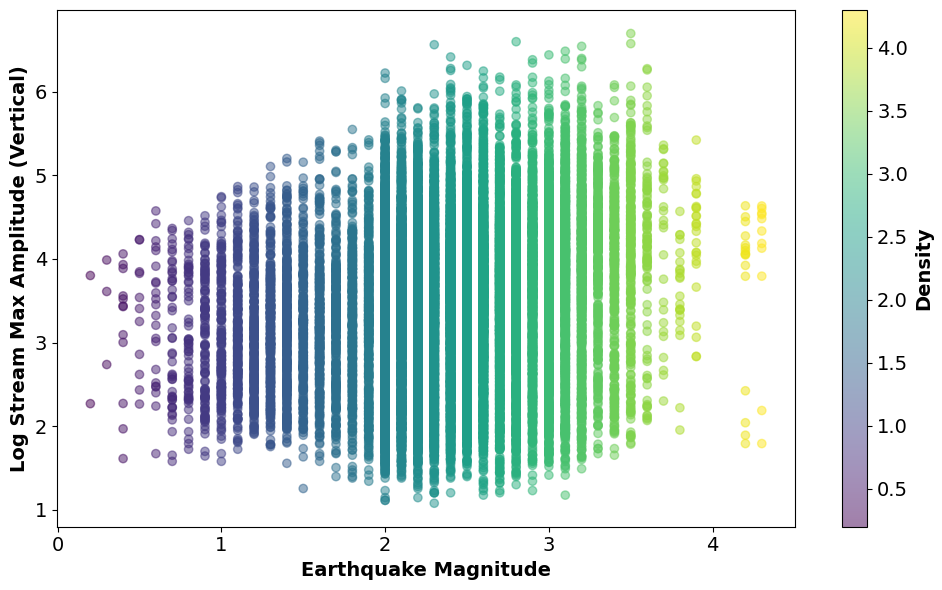

In [ ]:
# Scatter plot of log max values vs. labels for the vertical component
plt.figure(figsize=(10, 6))
scatter_log = plt.scatter(labels.numpy(), log_stream_max[:, vertical_index], alpha=0.5, c=labels.numpy(), cmap='viridis')
plt.xlabel('Earthquake Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Log Stream Max Amplitude (Vertical)', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
cbar = plt.colorbar(scatter_log)
cbar.set_label('Density', fontweight='bold', fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Additional analysis: Correlation between vertical max amplitude and magnitude
correlation = np.corrcoef(max_values[:, vertical_index], labels.numpy())[0, 1]
print(f"\nCorrelation between vertical stream max amplitude and earthquake magnitude: {correlation:.4f}")


Correlation between vertical stream max amplitude and earthquake magnitude: 0.1116


In [ ]:
# Additional analysis: Correlation between vertical log max amplitude and magnitude
correlation_log = np.corrcoef(log_stream_max[:, vertical_index], labels.numpy())[0, 1]
print(f"\nCorrelation between vertical log stream max amplitude and earthquake magnitude: {correlation_log:.4f}")


Correlation between vertical log stream max amplitude and earthquake magnitude: 0.2119


# Optional (Multi-observations >= 400)

In [ ]:
print(f"Number of records now: {len(filtered_metadata)}")

Number of records now: 28149


In [ ]:
# Implementing multi-observations with a threshold of >= 400
uniq_ins = filtered_metadata.station_code.unique()
labM = []
for ii in uniq_ins:
    stn = sum(filtered_metadata.station_code == ii)
    if stn >= 400:
        labM.append(ii)

print(f"Number of multi-observations: {len(labM)}")

# Filter the dataset to include only multi-observations
multi_obs_metadata = filtered_metadata[filtered_metadata.station_code.isin(labM)]

print(f"Number of records after multi-observation filtering: {len(multi_obs_metadata)}")

Number of multi-observations: 16
Number of records after multi-observation filtering: 9477


In [ ]:
# Get the list of valid events
valid_events = multi_obs_metadata.trace_name.tolist()

In [ ]:
def load_data_MO(instance_dataset, metadata):
    X = []
    Y = []
    log_stream_max = []

    hdf5_path = "/content/drive/My Drive/INSTANCE_Dataset/waveforms.hdf5"

    with h5py.File(hdf5_path, 'r') as hdf:
        for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
            try:
                trace_name = row['trace_name']
                sampling_rate = row['trace_sampling_rate_hz']

                # Parse the trace name
                bucket, trace_info = trace_name.split('$')
                trace_index = int(trace_info.split(',')[0])

                # Retrieve waveform data
                waveform = np.array(hdf['data'][bucket][trace_index])

                print(f"Processing {trace_name}")
                print(f"Waveform shape: {waveform.shape}")

                spt = int(row['trace_P_arrival_sample'])
                print(f"P arrival sample: {spt}")

                # Adjust window size based on sampling rate
                window_samples = int(30 * sampling_rate)  # 30 seconds window
                start = max(0, spt - int(5 * sampling_rate))  # 5 seconds before P arrival
                end = start + window_samples

                print(f"Window: start={start}, end={end}, window_samples={window_samples}")

                if start >= waveform.shape[1] or end > waveform.shape[1]:
                    print(f"Skipping event {trace_name}: Invalid window")
                    continue

                dshort = waveform[:, start:end]
                print(f"Windowed waveform shape: {dshort.shape}")

                # Ensure the shape is correct
                if dshort.shape[1] != window_samples:
                    print(f"Skipping event {trace_name}: Incorrect window size")
                    continue

                # Resample to 100 Hz if necessary
                if sampling_rate != 100:
                    dshort = scipy.signal.resample(dshort, (3, 3000), axis=1)

                X.append(dshort)
                Y.append(round(float(row['source_magnitude']), 2))

                # Extract log_stream_max
                max_values = np.max(np.abs(dshort), axis=1)
                log_max_values = np.log10(max_values + 1e-10)
                log_stream_max.append(log_max_values)

            except Exception as e:
                print(f"Error processing event {trace_name}: {e}")
                continue

    X = np.array(X)
    Y = np.array(Y)
    log_stream_max = np.array(log_stream_max)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), torch.tensor(log_stream_max, dtype=torch.float32)

In [ ]:
# Load and preprocess data
hdf5_path = "/content/drive/My Drive/INSTANCE_Dataset/waveforms.hdf5"
data_MO, labels_MO, log_stream_max_MO = load_data_MO(hdf5_path, multi_obs_metadata)

  1%|          | 82/9477 [00:00<00:22, 423.82it/s]

Processing bucket516$361,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2125
Window: start=1625, end=4625, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket516$354,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1682
Window: start=1182, end=4182, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket516$352,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2012
Window: start=1512, end=4512, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket516$362,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2046
Window: start=1546, end=4546, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket516$351,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1583
Window: start=1083, end=4083, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket516$374,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1976
Window: start=1476, end=4476, window_samples=3000
Windowed wavefo

  2%|▏         | 187/9477 [00:00<00:19, 487.23it/s]

Processing bucket519$641,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1707
Window: start=1207, end=4207, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket519$643,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2134
Window: start=1634, end=4634, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket519$647,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1698
Window: start=1198, end=4198, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket519$634,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1719
Window: start=1219, end=4219, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket519$657,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1871
Window: start=1371, end=4371, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket518$731,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2068
Window: start=1568, end=4568, window_samples=3000
Windowed wavefo

  3%|▎         | 286/9477 [00:00<00:18, 489.16it/s]

Processing bucket519$990,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1830
Window: start=1330, end=4330, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket522$24,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1841
Window: start=1341, end=4341, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket522$40,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2155
Window: start=1655, end=4655, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket522$41,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1880
Window: start=1380, end=4380, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket522$19,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1786
Window: start=1286, end=4286, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket520$73,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2092
Window: start=1592, end=4592, window_samples=3000
Windowed waveform sh

  4%|▍         | 394/9477 [00:00<00:17, 514.09it/s]

Processing bucket521$728,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1932
Window: start=1432, end=4432, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket521$725,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1866
Window: start=1366, end=4366, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket521$723,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2060
Window: start=1560, end=4560, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket521$756,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1855
Window: start=1355, end=4355, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket521$755,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1921
Window: start=1421, end=4421, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket522$699,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1639
Window: start=1139, end=4139, window_samples=3000
Windowed wavefo

  5%|▌         | 501/9477 [00:01<00:17, 520.88it/s]

Processing bucket524$390,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1910
Window: start=1410, end=4410, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket524$395,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1889
Window: start=1389, end=4389, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket524$398,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2102
Window: start=1602, end=4602, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket524$402,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1951
Window: start=1451, end=4451, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket524$403,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1814
Window: start=1314, end=4314, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket524$404,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1752
Window: start=1252, end=4252, window_samples=3000
Windowed wavefo

  6%|▋         | 606/9477 [00:01<00:17, 518.87it/s]

Processing bucket526$31,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1946
Window: start=1446, end=4446, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket526$30,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2127
Window: start=1627, end=4627, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket526$7,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1696
Window: start=1196, end=4196, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket526$8,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2098
Window: start=1598, end=4598, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket525$1012,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2154
Window: start=1654, end=4654, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket526$5,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1641
Window: start=1141, end=4141, window_samples=3000
Windowed waveform shap

  8%|▊         | 717/9477 [00:01<00:16, 536.00it/s]

Processing bucket536$13,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1755
Window: start=1255, end=4255, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket531$1,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2017
Window: start=1517, end=4517, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket531$67,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1741
Window: start=1241, end=4241, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket531$71,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1989
Window: start=1489, end=4489, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket531$72,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1848
Window: start=1348, end=4348, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket531$73,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1921
Window: start=1421, end=4421, window_samples=3000
Windowed waveform shap

  9%|▊         | 825/9477 [00:01<00:16, 531.03it/s]

Processing bucket532$395,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1716
Window: start=1216, end=4216, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket532$393,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1567
Window: start=1067, end=4067, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket532$398,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1836
Window: start=1336, end=4336, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket532$421,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1664
Window: start=1164, end=4164, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket532$409,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1639
Window: start=1139, end=4139, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket532$385,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2023
Window: start=1523, end=4523, window_samples=3000
Windowed wavefo

 10%|▉         | 933/9477 [00:01<00:16, 531.87it/s]

Processing bucket534$280,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1921
Window: start=1421, end=4421, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket534$284,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1982
Window: start=1482, end=4482, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket534$286,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1770
Window: start=1270, end=4270, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket534$287,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1596
Window: start=1096, end=4096, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket534$259,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1639
Window: start=1139, end=4139, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket534$240,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1712
Window: start=1212, end=4212, window_samples=3000
Windowed wavefo

 11%|█         | 1041/9477 [00:02<00:16, 522.60it/s]

Processing bucket545$6,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1951
Window: start=1451, end=4451, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket536$997,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1730
Window: start=1230, end=4230, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket536$1014,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1834
Window: start=1334, end=4334, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket536$1011,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1975
Window: start=1475, end=4475, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket536$1008,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1846
Window: start=1346, end=4346, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket536$1009,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2019
Window: start=1519, end=4519, window_samples=3000
Windowed wave

 12%|█▏        | 1148/9477 [00:02<00:15, 526.25it/s]

Processing bucket541$215,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1773
Window: start=1273, end=4273, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket541$216,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1814
Window: start=1314, end=4314, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket541$217,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1982
Window: start=1482, end=4482, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket541$218,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1857
Window: start=1357, end=4357, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket541$221,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1645
Window: start=1145, end=4145, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket541$226,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1676
Window: start=1176, end=4176, window_samples=3000
Windowed wavefo

 13%|█▎        | 1254/9477 [00:02<00:15, 527.50it/s]


Windowed waveform shape: (3, 3000)
Processing bucket540$674,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1626
Window: start=1126, end=4126, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket540$676,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1778
Window: start=1278, end=4278, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket540$677,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1705
Window: start=1205, end=4205, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket540$740,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1723
Window: start=1223, end=4223, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket540$736,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1900
Window: start=1400, end=4400, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket540$731,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1748
Window: start=1248, end=4248,

 14%|█▍        | 1362/9477 [00:02<00:15, 530.82it/s]

Waveform shape: (3, 12000)
P arrival sample: 2062
Window: start=1562, end=4562, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket541$847,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1946
Window: start=1446, end=4446, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket542$303,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1564
Window: start=1064, end=4064, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket542$297,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1760
Window: start=1260, end=4260, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket542$382,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1721
Window: start=1221, end=4221, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket542$381,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1868
Window: start=1368, end=4368, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing buck

 16%|█▌        | 1471/9477 [00:02<00:15, 532.30it/s]

Processing bucket543$259,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2139
Window: start=1639, end=4639, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket543$261,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1732
Window: start=1232, end=4232, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket543$262,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1780
Window: start=1280, end=4280, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket543$247,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1994
Window: start=1494, end=4494, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket543$246,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2017
Window: start=1517, end=4517, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket543$226,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1728
Window: start=1228, end=4228, window_samples=3000
Windowed wavefo

 17%|█▋        | 1578/9477 [00:03<00:15, 525.65it/s]

Processing bucket543$1013,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1589
Window: start=1089, end=4089, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket543$1012,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1628
Window: start=1128, end=4128, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket543$1001,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1769
Window: start=1269, end=4269, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket543$999,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1909
Window: start=1409, end=4409, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket546$115,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1968
Window: start=1468, end=4468, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket546$114,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1945
Window: start=1445, end=4445, window_samples=3000
Windowed wav

 18%|█▊        | 1685/9477 [00:03<00:14, 528.86it/s]

Processing bucket548$304,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1860
Window: start=1360, end=4360, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket548$302,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1994
Window: start=1494, end=4494, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket548$301,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1743
Window: start=1243, end=4243, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket548$306,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1694
Window: start=1194, end=4194, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket548$300,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1632
Window: start=1132, end=4132, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket546$768,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1727
Window: start=1227, end=4227, window_samples=3000
Windowed wavefo

 19%|█▉        | 1791/9477 [00:03<00:14, 527.06it/s]

Processing bucket547$971,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1648
Window: start=1148, end=4148, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket547$970,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1669
Window: start=1169, end=4169, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket549$60,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1669
Window: start=1169, end=4169, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket549$63,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1523
Window: start=1023, end=4023, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket549$62,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2163
Window: start=1663, end=4663, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket549$61,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1687
Window: start=1187, end=4187, window_samples=3000
Windowed waveform s

 20%|██        | 1901/9477 [00:03<00:14, 537.20it/s]

Processing bucket548$797,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1696
Window: start=1196, end=4196, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket548$796,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1726
Window: start=1226, end=4226, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket548$793,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1960
Window: start=1460, end=4460, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket548$814,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1787
Window: start=1287, end=4287, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket548$828,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1877
Window: start=1377, end=4377, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket548$827,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1861
Window: start=1361, end=4361, window_samples=3000
Windowed wavefo

 21%|██        | 2009/9477 [00:03<00:13, 536.15it/s]

Processing bucket549$864,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1987
Window: start=1487, end=4487, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket549$871,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2012
Window: start=1512, end=4512, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket549$818,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1980
Window: start=1480, end=4480, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket549$817,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1814
Window: start=1314, end=4314, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket549$820,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1798
Window: start=1298, end=4298, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket549$839,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2242
Window: start=1742, end=4742, window_samples=3000
Windowed wavefo

 22%|██▏       | 2118/9477 [00:04<00:13, 529.54it/s]

Processing bucket551$141,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2089
Window: start=1589, end=4589, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket551$139,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2138
Window: start=1638, end=4638, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket551$136,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1628
Window: start=1128, end=4128, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket550$413,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1637
Window: start=1137, end=4137, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket551$421,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2016
Window: start=1516, end=4516, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket551$426,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1623
Window: start=1123, end=4123, window_samples=3000
Windowed wavefo

 23%|██▎       | 2225/9477 [00:04<00:13, 529.25it/s]

Processing bucket551$941,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1848
Window: start=1348, end=4348, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket551$938,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1578
Window: start=1078, end=4078, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket551$956,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1939
Window: start=1439, end=4439, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket551$954,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2160
Window: start=1660, end=4660, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket551$953,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1673
Window: start=1173, end=4173, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket551$952,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1623
Window: start=1123, end=4123, window_samples=3000
Windowed wavefo

 25%|██▍       | 2334/9477 [00:04<00:13, 531.59it/s]

Processing bucket552$911,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1914
Window: start=1414, end=4414, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket552$912,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1816
Window: start=1316, end=4316, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket552$917,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1744
Window: start=1244, end=4244, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket552$919,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1730
Window: start=1230, end=4230, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket552$920,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1671
Window: start=1171, end=4171, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket552$918,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1648
Window: start=1148, end=4148, window_samples=3000
Windowed wavefo

 26%|██▌       | 2442/9477 [00:04<00:13, 526.57it/s]

Processing bucket556$424,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1980
Window: start=1480, end=4480, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket556$404,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1996
Window: start=1496, end=4496, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket556$420,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2076
Window: start=1576, end=4576, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket556$521,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1832
Window: start=1332, end=4332, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket556$520,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1912
Window: start=1412, end=4412, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket556$494,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1614
Window: start=1114, end=4114, window_samples=3000
Windowed wavefo

 27%|██▋       | 2548/9477 [00:04<00:13, 519.77it/s]

Processing bucket568$260,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1741
Window: start=1241, end=4241, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket568$264,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1757
Window: start=1257, end=4257, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket568$278,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1664
Window: start=1164, end=4164, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket568$256,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1946
Window: start=1446, end=4446, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket568$257,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2027
Window: start=1527, end=4527, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket568$241,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1986
Window: start=1486, end=4486, window_samples=3000
Windowed wavefo

 28%|██▊       | 2652/9477 [00:05<00:13, 518.07it/s]

Processing bucket564$322,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1923
Window: start=1423, end=4423, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket564$323,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1921
Window: start=1421, end=4421, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket564$327,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1851
Window: start=1351, end=4351, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket564$318,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2167
Window: start=1667, end=4667, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket564$366,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1892
Window: start=1392, end=4392, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket564$360,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1648
Window: start=1148, end=4148, window_samples=3000
Windowed wavefo

 29%|██▉       | 2756/9477 [00:05<00:13, 512.28it/s]

Processing bucket567$72,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1823
Window: start=1323, end=4323, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket567$71,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1871
Window: start=1371, end=4371, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket567$70,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1605
Window: start=1105, end=4105, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket567$69,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1572
Window: start=1072, end=4072, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket567$64,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1597
Window: start=1097, end=4097, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket567$43,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1900
Window: start=1400, end=4400, window_samples=3000
Windowed waveform sha

 30%|███       | 2860/9477 [00:05<00:12, 512.25it/s]

Processing bucket566$35,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1705
Window: start=1205, end=4205, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket567$513,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1753
Window: start=1253, end=4253, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket567$522,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1853
Window: start=1353, end=4353, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket567$519,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1620
Window: start=1120, end=4120, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket567$521,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2097
Window: start=1597, end=4597, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket567$508,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1769
Window: start=1269, end=4269, window_samples=3000
Windowed wavefor

 31%|███▏      | 2965/9477 [00:05<00:12, 514.81it/s]

Processing bucket571$263,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1948
Window: start=1448, end=4448, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket571$276,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1707
Window: start=1207, end=4207, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket571$261,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1800
Window: start=1300, end=4300, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket571$243,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1728
Window: start=1228, end=4228, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket571$245,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1987
Window: start=1487, end=4487, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket571$258,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1859
Window: start=1359, end=4359, window_samples=3000
Windowed wavefo

 32%|███▏      | 3072/9477 [00:05<00:12, 520.65it/s]

Processing bucket572$293,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1660
Window: start=1160, end=4160, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket572$292,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1789
Window: start=1289, end=4289, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket572$306,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2132
Window: start=1632, end=4632, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket572$284,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1880
Window: start=1380, end=4380, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket572$264,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1916
Window: start=1416, end=4416, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket572$268,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1848
Window: start=1348, end=4348, window_samples=3000
Windowed wavefo

 33%|███▎      | 3126/9477 [00:06<00:12, 525.57it/s]


P arrival sample: 1911
Window: start=1411, end=4411, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket576$876,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1939
Window: start=1439, end=4439, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket576$871,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1916
Window: start=1416, end=4416, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket576$872,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2043
Window: start=1543, end=4543, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket576$877,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1737
Window: start=1237, end=4237, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket576$878,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1769
Window: start=1269, end=4269, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket576$879,:3,:12000
Wavefo

 34%|███▍      | 3234/9477 [00:06<00:11, 527.37it/s]

Processing bucket586$106,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2063
Window: start=1563, end=4563, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket586$102,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1643
Window: start=1143, end=4143, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket579$543,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1864
Window: start=1364, end=4364, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket579$539,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1625
Window: start=1125, end=4125, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket579$549,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1914
Window: start=1414, end=4414, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket579$552,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1695
Window: start=1195, end=4195, window_samples=3000
Windowed wavefo

 35%|███▌      | 3345/9477 [00:06<00:11, 538.05it/s]

Processing bucket581$207,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1912
Window: start=1412, end=4412, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket581$204,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1911
Window: start=1411, end=4411, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket581$201,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1723
Window: start=1223, end=4223, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket581$192,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1578
Window: start=1078, end=4078, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket581$179,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1911
Window: start=1411, end=4411, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket581$163,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1645
Window: start=1145, end=4145, window_samples=3000
Windowed wavefo

 36%|███▋      | 3456/9477 [00:06<00:11, 542.57it/s]


P arrival sample: 1657
Window: start=1157, end=4157, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket582$925,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1871
Window: start=1371, end=4371, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket582$924,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2000
Window: start=1500, end=4500, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket582$923,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1567
Window: start=1067, end=4067, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket582$922,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1664
Window: start=1164, end=4164, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket582$915,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1960
Window: start=1460, end=4460, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket582$914,:3,:12000
Wavefo

 38%|███▊      | 3568/9477 [00:06<00:10, 548.61it/s]

Processing bucket585$632,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1641
Window: start=1141, end=4141, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket585$628,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1870
Window: start=1370, end=4370, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket585$633,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1607
Window: start=1107, end=4107, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket585$635,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1746
Window: start=1246, end=4246, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket585$637,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1755
Window: start=1255, end=4255, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket585$638,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1716
Window: start=1216, end=4216, window_samples=3000
Windowed wavefo

 39%|███▉      | 3679/9477 [00:07<00:10, 545.65it/s]

Processing bucket589$44,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2130
Window: start=1630, end=4630, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket589$50,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1812
Window: start=1312, end=4312, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket589$48,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1739
Window: start=1239, end=4239, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket589$124,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1998
Window: start=1498, end=4498, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket589$123,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2005
Window: start=1505, end=4505, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket589$118,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1882
Window: start=1382, end=4382, window_samples=3000
Windowed waveform 

 40%|████      | 3791/9477 [00:07<00:10, 544.57it/s]

Processing bucket595$268,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2225
Window: start=1725, end=4725, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket590$766,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1717
Window: start=1217, end=4217, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket590$765,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1707
Window: start=1207, end=4207, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket592$289,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1819
Window: start=1319, end=4319, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket592$314,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1643
Window: start=1143, end=4143, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket592$313,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1726
Window: start=1226, end=4226, window_samples=3000
Windowed wavefo

 41%|████      | 3901/9477 [00:07<00:10, 540.53it/s]

Processing bucket595$790,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2009
Window: start=1509, end=4509, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket595$775,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1935
Window: start=1435, end=4435, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket595$769,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1764
Window: start=1264, end=4264, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket595$774,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2210
Window: start=1710, end=4710, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket595$776,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1853
Window: start=1353, end=4353, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket595$817,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1930
Window: start=1430, end=4430, window_samples=3000
Windowed wavefo

 42%|████▏     | 4011/9477 [00:07<00:10, 541.17it/s]

Processing bucket594$292,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1567
Window: start=1067, end=4067, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket594$298,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1961
Window: start=1461, end=4461, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket594$296,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2042
Window: start=1542, end=4542, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket594$280,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2021
Window: start=1521, end=4521, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket594$271,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2102
Window: start=1602, end=4602, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket594$273,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2088
Window: start=1588, end=4588, window_samples=3000
Windowed wavefo

 44%|████▎     | 4124/9477 [00:07<00:09, 550.33it/s]

Window: start=1532, end=4532, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket596$943,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1882
Window: start=1382, end=4382, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket596$938,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1839
Window: start=1339, end=4339, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket596$939,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1830
Window: start=1330, end=4330, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket596$942,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1877
Window: start=1377, end=4377, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket596$944,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1676
Window: start=1176, end=4176, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket596$945,:3,:12000
Waveform shape: (3, 12000)
P a

 45%|████▍     | 4236/9477 [00:08<00:09, 549.88it/s]

Processing bucket598$298,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2011
Window: start=1511, end=4511, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket598$302,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1576
Window: start=1076, end=4076, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket598$747,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1807
Window: start=1307, end=4307, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket598$762,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1996
Window: start=1496, end=4496, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket598$767,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1780
Window: start=1280, end=4280, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket599$416,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1805
Window: start=1305, end=4305, window_samples=3000
Windowed wavefo

 46%|████▌     | 4346/9477 [00:08<00:09, 546.52it/s]

P arrival sample: 1937
Window: start=1437, end=4437, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket601$19,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2098
Window: start=1598, end=4598, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket601$17,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1607
Window: start=1107, end=4107, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket601$145,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1800
Window: start=1300, end=4300, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket601$143,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2076
Window: start=1576, end=4576, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket601$140,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1628
Window: start=1128, end=4128, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket601$138,:3,:12000
Waveform 

 47%|████▋     | 4458/9477 [00:08<00:09, 551.89it/s]


P arrival sample: 1712
Window: start=1212, end=4212, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket603$391,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1987
Window: start=1487, end=4487, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket601$975,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1714
Window: start=1214, end=4214, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket603$481,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1625
Window: start=1125, end=4125, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket603$480,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1630
Window: start=1130, end=4130, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket603$470,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1616
Window: start=1116, end=4116, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket603$469,:3,:12000
Wavefo

 48%|████▊     | 4570/9477 [00:08<00:08, 553.04it/s]

Processing bucket605$541,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1668
Window: start=1168, end=4168, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket605$537,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1671
Window: start=1171, end=4171, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket605$529,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1680
Window: start=1180, end=4180, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket603$979,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1984
Window: start=1484, end=4484, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket603$980,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1951
Window: start=1451, end=4451, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket602$954,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1581
Window: start=1081, end=4081, window_samples=3000
Windowed wavefo

 49%|████▉     | 4682/9477 [00:08<00:08, 550.23it/s]

Processing bucket604$414,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1930
Window: start=1430, end=4430, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket604$413,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2187
Window: start=1687, end=4687, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket604$408,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1605
Window: start=1105, end=4105, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket604$407,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1695
Window: start=1195, end=4195, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket604$403,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1680
Window: start=1180, end=4180, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket604$398,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1896
Window: start=1396, end=4396, window_samples=3000
Windowed wavefo

 51%|█████     | 4793/9477 [00:09<00:08, 544.26it/s]

Processing bucket607$292,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1914
Window: start=1414, end=4414, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket606$780,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1895
Window: start=1395, end=4395, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket606$787,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1607
Window: start=1107, end=4107, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket606$782,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2028
Window: start=1528, end=4528, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket606$783,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1998
Window: start=1498, end=4498, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket606$756,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1862
Window: start=1362, end=4362, window_samples=3000
Windowed wavefo

 52%|█████▏    | 4903/9477 [00:09<00:08, 539.55it/s]

Processing bucket608$838,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1805
Window: start=1305, end=4305, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket608$843,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1725
Window: start=1225, end=4225, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket608$835,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1720
Window: start=1220, end=4220, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket608$834,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1583
Window: start=1083, end=4083, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket608$847,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1846
Window: start=1346, end=4346, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket608$849,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1953
Window: start=1453, end=4453, window_samples=3000
Windowed wavefo

 53%|█████▎    | 5014/9477 [00:09<00:08, 544.47it/s]

Processing bucket609$871,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2194
Window: start=1694, end=4694, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket611$40,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1623
Window: start=1123, end=4123, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket611$41,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1661
Window: start=1161, end=4161, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket611$44,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1625
Window: start=1125, end=4125, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket611$42,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1823
Window: start=1323, end=4323, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket611$37,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1680
Window: start=1180, end=4180, window_samples=3000
Windowed waveform sh

 54%|█████▍    | 5125/9477 [00:09<00:07, 548.60it/s]

Windowed waveform shape: (3, 3000)
Processing bucket613$231,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1994
Window: start=1494, end=4494, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket613$228,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1955
Window: start=1455, end=4455, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket613$227,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1987
Window: start=1487, end=4487, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket613$216,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1556
Window: start=1056, end=4056, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket613$192,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1680
Window: start=1180, end=4180, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket613$184,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2246
Window: start=1746, end=4746, 

 55%|█████▌    | 5238/9477 [00:09<00:07, 552.80it/s]

Processing bucket613$647,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1802
Window: start=1302, end=4302, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket613$671,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1919
Window: start=1419, end=4419, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket613$672,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1912
Window: start=1412, end=4412, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket614$82,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2266
Window: start=1766, end=4766, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket614$83,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1982
Window: start=1482, end=4482, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket614$36,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2021
Window: start=1521, end=4521, window_samples=3000
Windowed waveform 

 56%|█████▋    | 5350/9477 [00:10<00:07, 549.38it/s]

Processing bucket617$874,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1945
Window: start=1445, end=4445, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket617$875,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2046
Window: start=1546, end=4546, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket617$877,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1914
Window: start=1414, end=4414, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket617$878,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1728
Window: start=1228, end=4228, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket617$873,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1882
Window: start=1382, end=4382, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket617$864,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2053
Window: start=1553, end=4553, window_samples=3000
Windowed wavefo

 58%|█████▊    | 5461/9477 [00:10<00:07, 547.25it/s]


P arrival sample: 1819
Window: start=1319, end=4319, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket627$469,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1582
Window: start=1082, end=4082, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket627$479,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1744
Window: start=1244, end=4244, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket627$478,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1770
Window: start=1270, end=4270, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket627$475,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2071
Window: start=1571, end=4571, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket627$415,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1667
Window: start=1167, end=4167, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket627$414,:3,:12000
Wavefo

 59%|█████▉    | 5571/9477 [00:10<00:07, 541.51it/s]

Processing bucket626$197,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1786
Window: start=1286, end=4286, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket626$192,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1597
Window: start=1097, end=4097, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket626$180,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2011
Window: start=1511, end=4511, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket626$190,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1746
Window: start=1246, end=4246, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket626$191,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1753
Window: start=1253, end=4253, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket626$194,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1544
Window: start=1044, end=4044, window_samples=3000
Windowed wavefo

 60%|█████▉    | 5681/9477 [00:10<00:07, 541.82it/s]

Processing bucket628$103,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1992
Window: start=1492, end=4492, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket626$829,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1732
Window: start=1232, end=4232, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket628$298,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1771
Window: start=1271, end=4271, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket628$304,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1848
Window: start=1348, end=4348, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket628$285,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1714
Window: start=1214, end=4214, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket628$297,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1821
Window: start=1321, end=4321, window_samples=3000
Windowed wavefo

 61%|██████    | 5793/9477 [00:10<00:06, 549.67it/s]

Processing bucket630$1004,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1825
Window: start=1325, end=4325, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket630$1015,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1614
Window: start=1114, end=4114, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket630$1016,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1558
Window: start=1058, end=4058, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket630$1012,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1943
Window: start=1443, end=4443, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket635$271,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2065
Window: start=1565, end=4565, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket631$567,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2102
Window: start=1602, end=4602, window_samples=3000
Windowed wa

 62%|██████▏   | 5904/9477 [00:11<00:06, 551.78it/s]


P arrival sample: 1563
Window: start=1063, end=4063, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket633$997,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1937
Window: start=1437, end=4437, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket633$995,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2020
Window: start=1520, end=4520, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket633$981,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1536
Window: start=1036, end=4036, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket633$996,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1794
Window: start=1294, end=4294, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket633$984,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1823
Window: start=1323, end=4323, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket633$989,:3,:12000
Wavefo

 63%|██████▎   | 6017/9477 [00:11<00:06, 551.59it/s]

Processing bucket636$313,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1930
Window: start=1430, end=4430, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket636$318,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1917
Window: start=1417, end=4417, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket636$314,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1973
Window: start=1473, end=4473, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket636$312,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1885
Window: start=1385, end=4385, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket636$311,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1850
Window: start=1350, end=4350, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket636$302,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1780
Window: start=1280, end=4280, window_samples=3000
Windowed wavefo

 65%|██████▍   | 6129/9477 [00:11<00:06, 551.71it/s]

Processing bucket640$197,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1845
Window: start=1345, end=4345, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket640$175,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1814
Window: start=1314, end=4314, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket640$173,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1583
Window: start=1083, end=4083, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket640$198,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2155
Window: start=1655, end=4655, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket640$199,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1998
Window: start=1498, end=4498, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket640$191,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1807
Window: start=1307, end=4307, window_samples=3000
Windowed wavefo

 66%|██████▌   | 6242/9477 [00:11<00:05, 555.82it/s]

Processing bucket641$677,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1812
Window: start=1312, end=4312, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket641$680,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1877
Window: start=1377, end=4377, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket641$659,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1957
Window: start=1457, end=4457, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket641$676,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1721
Window: start=1221, end=4221, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket641$669,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1925
Window: start=1425, end=4425, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket641$668,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1561
Window: start=1061, end=4061, window_samples=3000
Windowed wavefo

 67%|██████▋   | 6355/9477 [00:11<00:05, 554.24it/s]

Processing bucket643$832,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1687
Window: start=1187, end=4187, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket643$833,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1676
Window: start=1176, end=4176, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket643$853,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2011
Window: start=1511, end=4511, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket643$854,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2003
Window: start=1503, end=4503, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket644$75,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1785
Window: start=1285, end=4285, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket644$85,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1809
Window: start=1309, end=4309, window_samples=3000
Windowed waveform

 68%|██████▊   | 6468/9477 [00:12<00:05, 550.89it/s]

Processing bucket645$437,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1782
Window: start=1282, end=4282, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket645$433,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2010
Window: start=1510, end=4510, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket646$391,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1639
Window: start=1139, end=4139, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket646$389,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1914
Window: start=1414, end=4414, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket646$394,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1791
Window: start=1291, end=4291, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket646$388,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1939
Window: start=1439, end=4439, window_samples=3000
Windowed wavefo

 69%|██████▉   | 6579/9477 [00:12<00:05, 545.46it/s]

Processing bucket647$222,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1764
Window: start=1264, end=4264, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket647$224,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2161
Window: start=1661, end=4661, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket647$237,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2014
Window: start=1514, end=4514, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket647$233,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2037
Window: start=1537, end=4537, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket647$234,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2035
Window: start=1535, end=4535, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket650$6,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2067
Window: start=1567, end=4567, window_samples=3000
Windowed waveform

 71%|███████   | 6690/9477 [00:12<00:05, 547.53it/s]

Processing bucket652$10,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1623
Window: start=1123, end=4123, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket652$12,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1973
Window: start=1473, end=4473, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket652$126,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1796
Window: start=1296, end=4296, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket652$279,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1794
Window: start=1294, end=4294, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket652$283,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1664
Window: start=1164, end=4164, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket652$286,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2037
Window: start=1537, end=4537, window_samples=3000
Windowed waveform

 72%|███████▏  | 6800/9477 [00:12<00:04, 542.18it/s]

Processing bucket653$13,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2140
Window: start=1640, end=4640, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket653$14,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2084
Window: start=1584, end=4584, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket657$411,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1905
Window: start=1405, end=4405, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket657$404,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1986
Window: start=1486, end=4486, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket653$289,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1946
Window: start=1446, end=4446, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket653$292,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1632
Window: start=1132, end=4132, window_samples=3000
Windowed waveform

 73%|███████▎  | 6909/9477 [00:12<00:04, 534.18it/s]

Processing bucket654$279,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1561
Window: start=1061, end=4061, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket654$260,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1614
Window: start=1114, end=4114, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket654$258,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1768
Window: start=1268, end=4268, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket654$257,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1755
Window: start=1255, end=4255, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket654$266,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1792
Window: start=1292, end=4292, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket654$280,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1577
Window: start=1077, end=4077, window_samples=3000
Windowed wavefo

 74%|███████▍  | 7016/9477 [00:13<00:04, 522.95it/s]

Processing bucket654$791,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1853
Window: start=1353, end=4353, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$2,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1889
Window: start=1389, end=4389, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$1,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1887
Window: start=1387, end=4387, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$0,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1755
Window: start=1255, end=4255, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket654$1023,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1709
Window: start=1209, end=4209, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$9,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1861
Window: start=1361, end=4361, window_samples=3000
Windowed waveform shap

 75%|███████▌  | 7129/9477 [00:13<00:04, 541.61it/s]

Processing bucket656$447,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1574
Window: start=1074, end=4074, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$463,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2066
Window: start=1566, end=4566, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$462,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2108
Window: start=1608, end=4608, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$452,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2066
Window: start=1566, end=4566, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$451,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1675
Window: start=1175, end=4175, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$450,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1653
Window: start=1153, end=4153, window_samples=3000
Windowed wavefo

 76%|███████▋  | 7240/9477 [00:13<00:04, 534.50it/s]

Processing bucket656$916,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1916
Window: start=1416, end=4416, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$921,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1841
Window: start=1341, end=4341, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$922,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1569
Window: start=1069, end=4069, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$927,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1812
Window: start=1312, end=4312, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$932,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1742
Window: start=1242, end=4242, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket656$933,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1778
Window: start=1278, end=4278, window_samples=3000
Windowed wavefo

 78%|███████▊  | 7348/9477 [00:13<00:04, 530.80it/s]

Processing bucket657$978,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1837
Window: start=1337, end=4337, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket657$979,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1887
Window: start=1387, end=4387, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket657$964,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1678
Window: start=1178, end=4178, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket657$963,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1660
Window: start=1160, end=4160, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket657$955,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1876
Window: start=1376, end=4376, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket659$683,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1714
Window: start=1214, end=4214, window_samples=3000
Windowed wavefo

 79%|███████▊  | 7457/9477 [00:13<00:03, 535.26it/s]


Windowed waveform shape: (3, 3000)
Processing bucket662$12,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1787
Window: start=1287, end=4287, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket660$998,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2005
Window: start=1505, end=4505, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket660$999,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2085
Window: start=1585, end=4585, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket660$1001,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1901
Window: start=1401, end=4401, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket660$1007,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1548
Window: start=1048, end=4048, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket662$3,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2106
Window: start=1606, end=4606, 

 80%|███████▉  | 7567/9477 [00:14<00:03, 540.25it/s]

Processing bucket664$624,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2093
Window: start=1593, end=4593, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket664$622,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1945
Window: start=1445, end=4445, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket664$621,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1957
Window: start=1457, end=4457, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket664$637,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1875
Window: start=1375, end=4375, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket664$649,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1810
Window: start=1310, end=4310, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket664$641,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1973
Window: start=1473, end=4473, window_samples=3000
Windowed wavefo

 81%|████████  | 7676/9477 [00:14<00:03, 532.20it/s]

Processing bucket662$746,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2173
Window: start=1673, end=4673, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket662$741,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1777
Window: start=1277, end=4277, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket662$770,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1946
Window: start=1446, end=4446, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket662$771,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1905
Window: start=1405, end=4405, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket662$796,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1780
Window: start=1280, end=4280, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket662$802,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2043
Window: start=1543, end=4543, window_samples=3000
Windowed wavefo

 82%|████████▏ | 7786/9477 [00:14<00:03, 534.24it/s]

Processing bucket663$869,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1534
Window: start=1034, end=4034, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket663$864,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1725
Window: start=1225, end=4225, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket666$3,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1771
Window: start=1271, end=4271, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket666$18,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1694
Window: start=1194, end=4194, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket666$19,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1623
Window: start=1123, end=4123, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket666$11,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1737
Window: start=1237, end=4237, window_samples=3000
Windowed waveform sh

 83%|████████▎ | 7895/9477 [00:14<00:02, 536.45it/s]

P arrival sample: 1534
Window: start=1034, end=4034, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket672$11,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1803
Window: start=1303, end=4303, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket664$1021,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1771
Window: start=1271, end=4271, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket664$1020,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1773
Window: start=1273, end=4273, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket664$1019,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1919
Window: start=1419, end=4419, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket664$1018,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1964
Window: start=1464, end=4464, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket664$1012,:3,:12000
Wav

 84%|████████▍ | 8003/9477 [00:14<00:02, 534.98it/s]

Processing bucket667$264,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1939
Window: start=1439, end=4439, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket667$265,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1928
Window: start=1428, end=4428, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket667$268,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1978
Window: start=1478, end=4478, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket667$271,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2065
Window: start=1565, end=4565, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket667$276,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1961
Window: start=1461, end=4461, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket667$278,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2167
Window: start=1667, end=4667, window_samples=3000
Windowed wavefo

 86%|████████▌ | 8111/9477 [00:15<00:02, 534.42it/s]

Processing bucket670$580,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1766
Window: start=1266, end=4266, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket670$581,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1823
Window: start=1323, end=4323, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket670$616,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1878
Window: start=1378, end=4378, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket670$615,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1921
Window: start=1421, end=4421, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket670$621,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2063
Window: start=1563, end=4563, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket670$736,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1634
Window: start=1134, end=4134, window_samples=3000
Windowed wavefo

 87%|████████▋ | 8218/9477 [00:15<00:02, 525.94it/s]


Windowed waveform shape: (3, 3000)
Processing bucket672$939,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2036
Window: start=1536, end=4536, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket672$972,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1753
Window: start=1253, end=4253, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket672$971,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1839
Window: start=1339, end=4339, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket672$969,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1641
Window: start=1141, end=4141, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket672$959,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1937
Window: start=1437, end=4437, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket672$958,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2088
Window: start=1588, end=4588,

 88%|████████▊ | 8327/9477 [00:15<00:02, 533.15it/s]

Processing bucket674$826,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1950
Window: start=1450, end=4450, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket674$827,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1927
Window: start=1427, end=4427, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket674$829,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1875
Window: start=1375, end=4375, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket674$834,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1627
Window: start=1127, end=4127, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket674$835,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1639
Window: start=1139, end=4139, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket674$836,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1641
Window: start=1141, end=4141, window_samples=3000
Windowed wavefo

 89%|████████▉ | 8437/9477 [00:15<00:01, 538.28it/s]

Processing bucket676$1014,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1828
Window: start=1328, end=4328, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket676$1012,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2017
Window: start=1517, end=4517, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket678$3,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1830
Window: start=1330, end=4330, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket678$1,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1992
Window: start=1492, end=4492, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket678$2,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2005
Window: start=1505, end=4505, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket678$155,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1952
Window: start=1452, end=4452, window_samples=3000
Windowed waveform s

 90%|█████████ | 8545/9477 [00:16<00:01, 536.10it/s]

Processing bucket681$926,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1789
Window: start=1289, end=4289, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket681$936,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2058
Window: start=1558, end=4558, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket681$921,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2171
Window: start=1671, end=4671, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket681$922,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2032
Window: start=1532, end=4532, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket681$920,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1953
Window: start=1453, end=4453, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket680$907,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2003
Window: start=1503, end=4503, window_samples=3000
Windowed wavefo

 91%|█████████▏| 8653/9477 [00:16<00:01, 533.99it/s]


Windowed waveform shape: (3, 3000)
Processing bucket684$842,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1876
Window: start=1376, end=4376, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket684$857,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1914
Window: start=1414, end=4414, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket684$856,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1782
Window: start=1282, end=4282, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket684$854,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1761
Window: start=1261, end=4261, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket684$855,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1721
Window: start=1221, end=4221, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket684$950,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1627
Window: start=1127, end=4127,

 92%|█████████▏| 8762/9477 [00:16<00:01, 538.25it/s]

Processing bucket690$49,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1866
Window: start=1366, end=4366, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket690$70,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1880
Window: start=1380, end=4380, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket690$55,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1842
Window: start=1342, end=4342, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket690$56,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1945
Window: start=1445, end=4445, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket690$63,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1903
Window: start=1403, end=4403, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket690$292,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1746
Window: start=1246, end=4246, window_samples=3000
Windowed waveform sh

 94%|█████████▎| 8870/9477 [00:16<00:01, 537.73it/s]

Processing bucket692$54,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1657
Window: start=1157, end=4157, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket692$45,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1862
Window: start=1362, end=4362, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket692$285,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1786
Window: start=1286, end=4286, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket692$286,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1841
Window: start=1341, end=4341, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket692$274,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1580
Window: start=1080, end=4080, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket692$275,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2110
Window: start=1610, end=4610, window_samples=3000
Windowed waveform

 95%|█████████▍| 8979/9477 [00:16<00:00, 536.46it/s]

P arrival sample: 2021
Window: start=1521, end=4521, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket694$266,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2050
Window: start=1550, end=4550, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket693$430,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1646
Window: start=1146, end=4146, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket693$442,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1870
Window: start=1370, end=4370, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket693$433,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1757
Window: start=1257, end=4257, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket693$417,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1812
Window: start=1312, end=4312, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket694$294,:3,:12000
Wavefor

 96%|█████████▌| 9087/9477 [00:17<00:00, 536.04it/s]

Processing bucket698$756,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2001
Window: start=1501, end=4501, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket697$587,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1671
Window: start=1171, end=4171, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket697$583,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2030
Window: start=1530, end=4530, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket697$607,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1917
Window: start=1417, end=4417, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket697$598,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1650
Window: start=1150, end=4150, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket697$594,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1971
Window: start=1471, end=4471, window_samples=3000
Windowed wavefo

 97%|█████████▋| 9198/9477 [00:17<00:00, 543.61it/s]

Processing bucket702$281,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2196
Window: start=1696, end=4696, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket702$274,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2120
Window: start=1620, end=4620, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket701$20,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2017
Window: start=1517, end=4517, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket701$21,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1996
Window: start=1496, end=4496, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket701$23,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1677
Window: start=1177, end=4177, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket701$19,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1769
Window: start=1269, end=4269, window_samples=3000
Windowed waveform s

 98%|█████████▊| 9310/9477 [00:17<00:00, 549.56it/s]

Windowed waveform shape: (3, 3000)
Processing bucket702$1012,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1770
Window: start=1270, end=4270, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket703$692,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1655
Window: start=1155, end=4155, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket708$406,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1742
Window: start=1242, end=4242, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket708$405,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1720
Window: start=1220, end=4220, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket708$404,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2018
Window: start=1518, end=4518, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket708$403,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2035
Window: start=1535, end=4535,

 99%|█████████▉| 9420/9477 [00:17<00:00, 544.99it/s]

Processing bucket705$753,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1934
Window: start=1434, end=4434, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket705$762,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1860
Window: start=1360, end=4360, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket705$769,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2005
Window: start=1505, end=4505, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket705$771,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1737
Window: start=1237, end=4237, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket705$770,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1728
Window: start=1228, end=4228, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket705$758,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1686
Window: start=1186, end=4186, window_samples=3000
Windowed wavefo

100%|██████████| 9477/9477 [00:17<00:00, 534.64it/s]


Processing bucket708$961,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1980
Window: start=1480, end=4480, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket708$959,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1745
Window: start=1245, end=4245, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket708$958,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1953
Window: start=1453, end=4453, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket708$956,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 1966
Window: start=1466, end=4466, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket708$955,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2060
Window: start=1560, end=4560, window_samples=3000
Windowed waveform shape: (3, 3000)
Processing bucket708$954,:3,:12000
Waveform shape: (3, 12000)
P arrival sample: 2012
Window: start=1512, end=4512, window_samples=3000
Windowed wavefo

In [ ]:
print(f"Data shape: {data_MO.shape}")
print(f"Labels shape: {labels_MO.shape}")
print(f"Log stream max shape: {log_stream_max_MO.shape}")

Data shape: torch.Size([9477, 3, 3000])
Labels shape: torch.Size([9477])
Log stream max shape: torch.Size([9477, 3])


In [ ]:
# # Save preprocessed data to Google Drive
# output_data_file_MO = "/content/drive/MyDrive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/Notebooks/EDA/INSTANCE/MO_INSTANCE_pre_processed_data.npy"
# output_labels_file_MO = "/content/drive/MyDrive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/Notebooks/EDA/INSTANCE/MO_INSTANCE_pre_processed_labels.npy"
# output_log_stream_max_file_MO = "/content/drive/MyDrive/2023-2024/UCL MSc in DSML/Term 3/MSc Project/Code/Notebooks/EDA/INSTANCE/MO_INSTANCE_log_stream_max.npy"

# np.save(output_data_file_MO, data.numpy())
# np.save(output_labels_file_MO, labels.numpy())
# np.save(output_log_stream_max_file_MO, log_stream_max.numpy())

# print(f"Preprocessed data saved to {output_data_file_MO}")
# print(f"Preprocessed labels saved to {output_labels_file_MO}")
# print(f"Log stream max values saved to {output_log_stream_max_file_MO}")

In [ ]:
print("Multi-observations >= 400: Job done!!!")

Multi-observations >= 400: Job done!!!


In [ ]:
# Recalculate max_values
max_values_MO = 10**(np.array(log_stream_max_MO)) - 1e-10

# Ensure the shape matches log_stream_max
assert max_values_MO.shape == log_stream_max_MO.shape, "Shapes do not match!"

# Print the shape to confirm
print("Recovered max_values shape:", max_values_MO.shape)

Recovered max_values shape: (9477, 3)


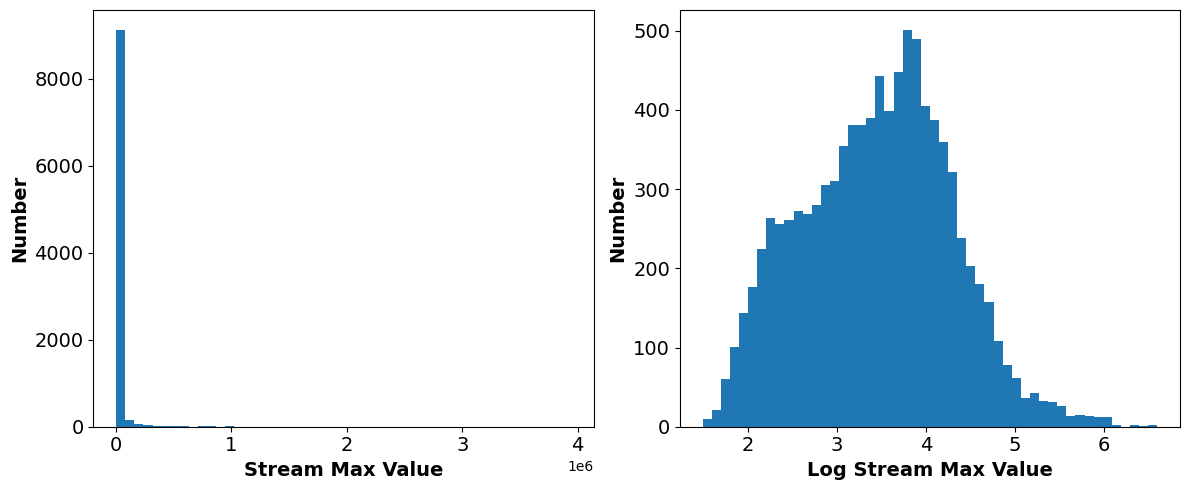

In [ ]:
# Plot histograms of max values and log max values for the vertical component
vertical_index_MO = 0

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(max_values_MO[:, vertical_index_MO], bins=50)  # No need for .numpy() here
plt.xlabel('Stream Max Value', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.subplot(1, 2, 2)
plt.hist(log_stream_max_MO[:, vertical_index_MO], bins=50)  # No need for .numpy() here
plt.xlabel('Log Stream Max Value', fontweight='bold', fontsize=14)
plt.ylabel('Number', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

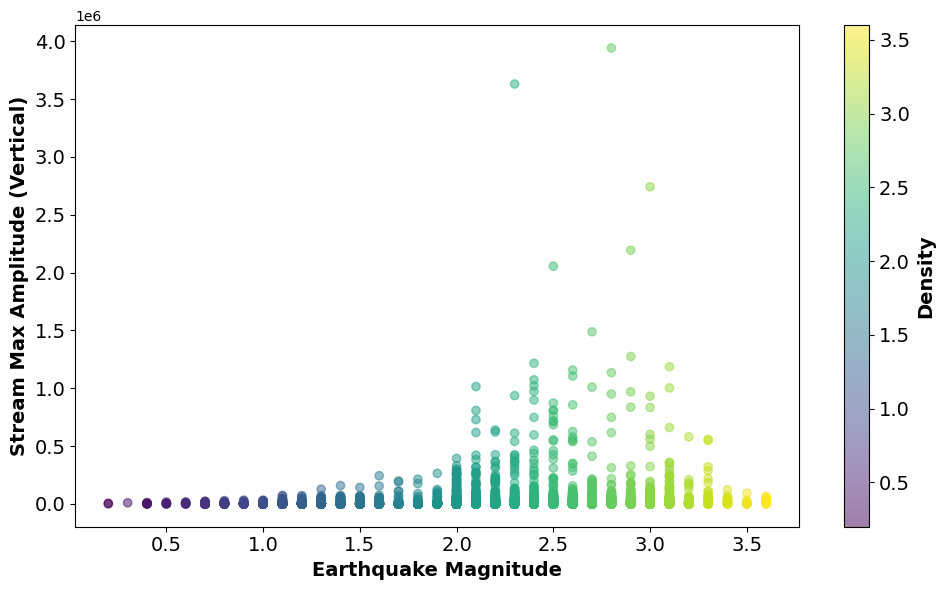

In [ ]:
# Scatter plot of max values vs. labels for the vertical component
plt.figure(figsize=(10, 6))
scatter = plt.scatter(labels_MO.numpy(), max_values_MO[:, vertical_index_MO], alpha=0.5, c=labels_MO.numpy(), cmap='viridis')
plt.xlabel('Earthquake Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Stream Max Amplitude (Vertical)', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
cbar = plt.colorbar(scatter)
cbar.set_label('Density', fontweight='bold', fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

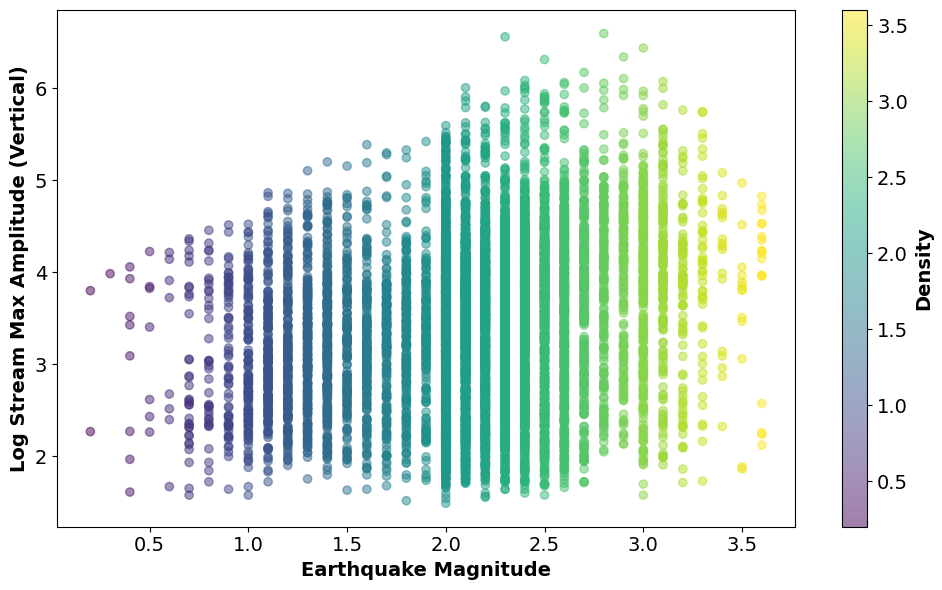

In [ ]:
# Scatter plot of log max values vs. labels for the vertical component
plt.figure(figsize=(10, 6))
scatter_log = plt.scatter(labels_MO.numpy(), log_stream_max_MO[:, vertical_index_MO], alpha=0.5, c=labels_MO.numpy(), cmap='viridis')
plt.xlabel('Earthquake Magnitude', fontweight='bold', fontsize=14)
plt.ylabel('Log Stream Max Amplitude (Vertical)', fontweight='bold', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
cbar = plt.colorbar(scatter_log)
cbar.set_label('Density', fontweight='bold', fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Additional analysis: Correlation between vertical max amplitude and magnitude
correlation_MO = np.corrcoef(max_values_MO[:, vertical_index_MO], labels_MO.numpy())[0, 1]
print(f"\nCorrelation between vertical stream max amplitude and earthquake magnitude: {correlation_MO:.4f}")


Correlation between vertical stream max amplitude and earthquake magnitude: 0.1150


In [ ]:
# Additional analysis: Correlation between vertical log max amplitude and magnitude
correlation_log_MO = np.corrcoef(log_stream_max_MO[:, vertical_index_MO], labels_MO.numpy())[0, 1]
print(f"\nCorrelation between vertical log stream max amplitude and earthquake magnitude: {correlation_log_MO:.4f}")


Correlation between vertical log stream max amplitude and earthquake magnitude: 0.2289


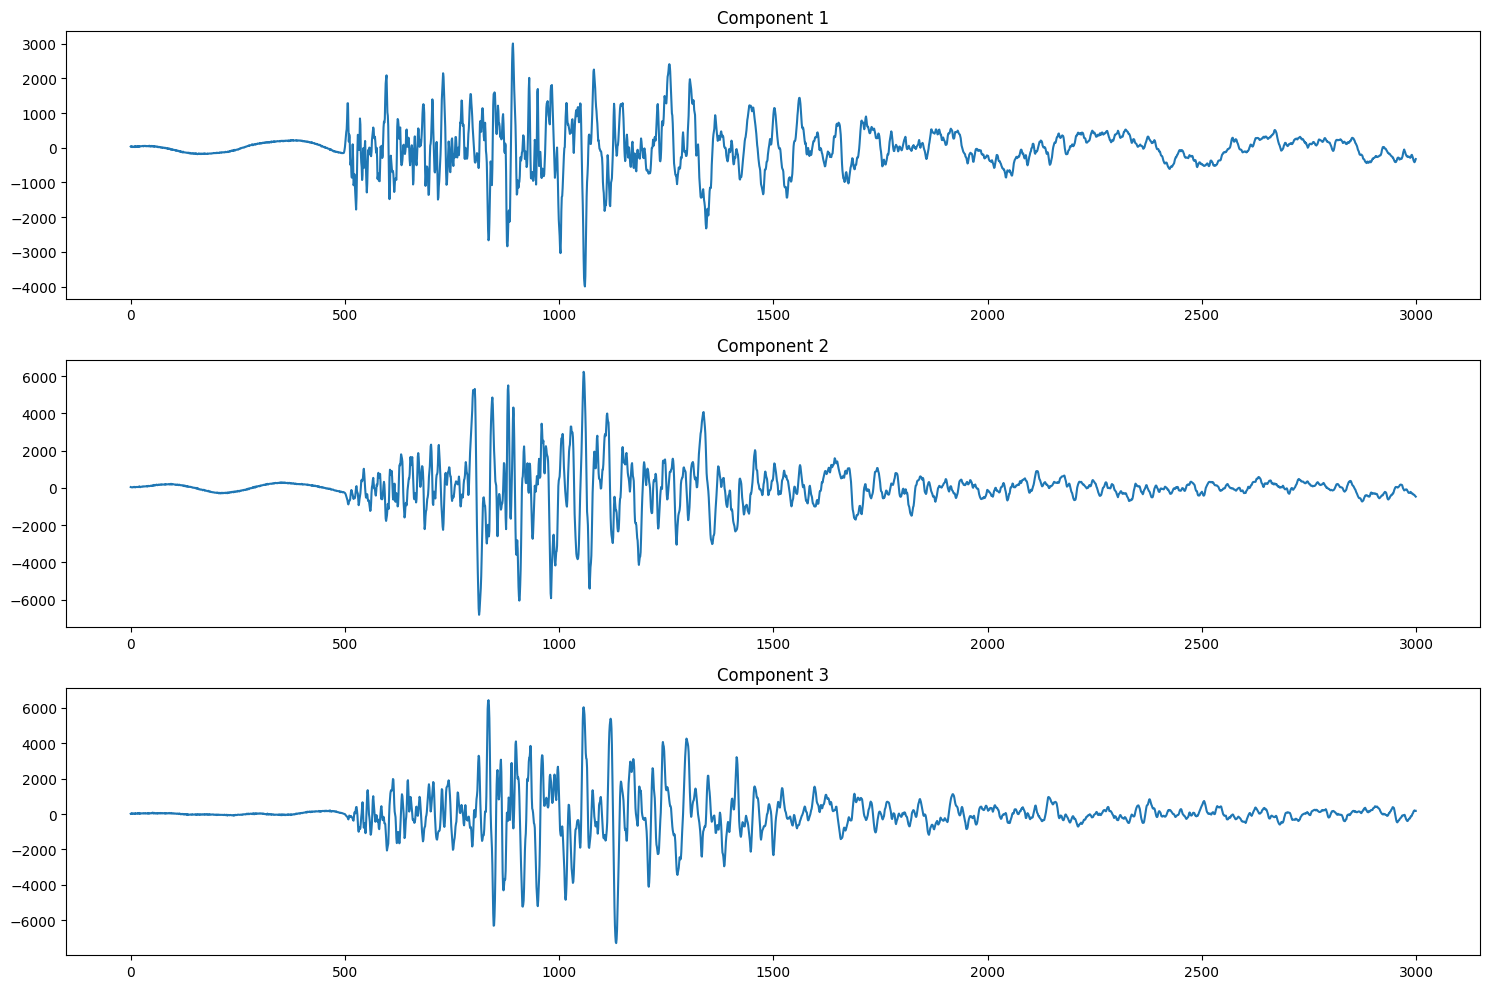

In [ ]:
# Plot a sample waveform
sample_index = 4500
plt.figure(figsize=(15, 10))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(data_MO[sample_index][i])
    plt.title(f'Component {i+1}')
plt.tight_layout()
plt.show()

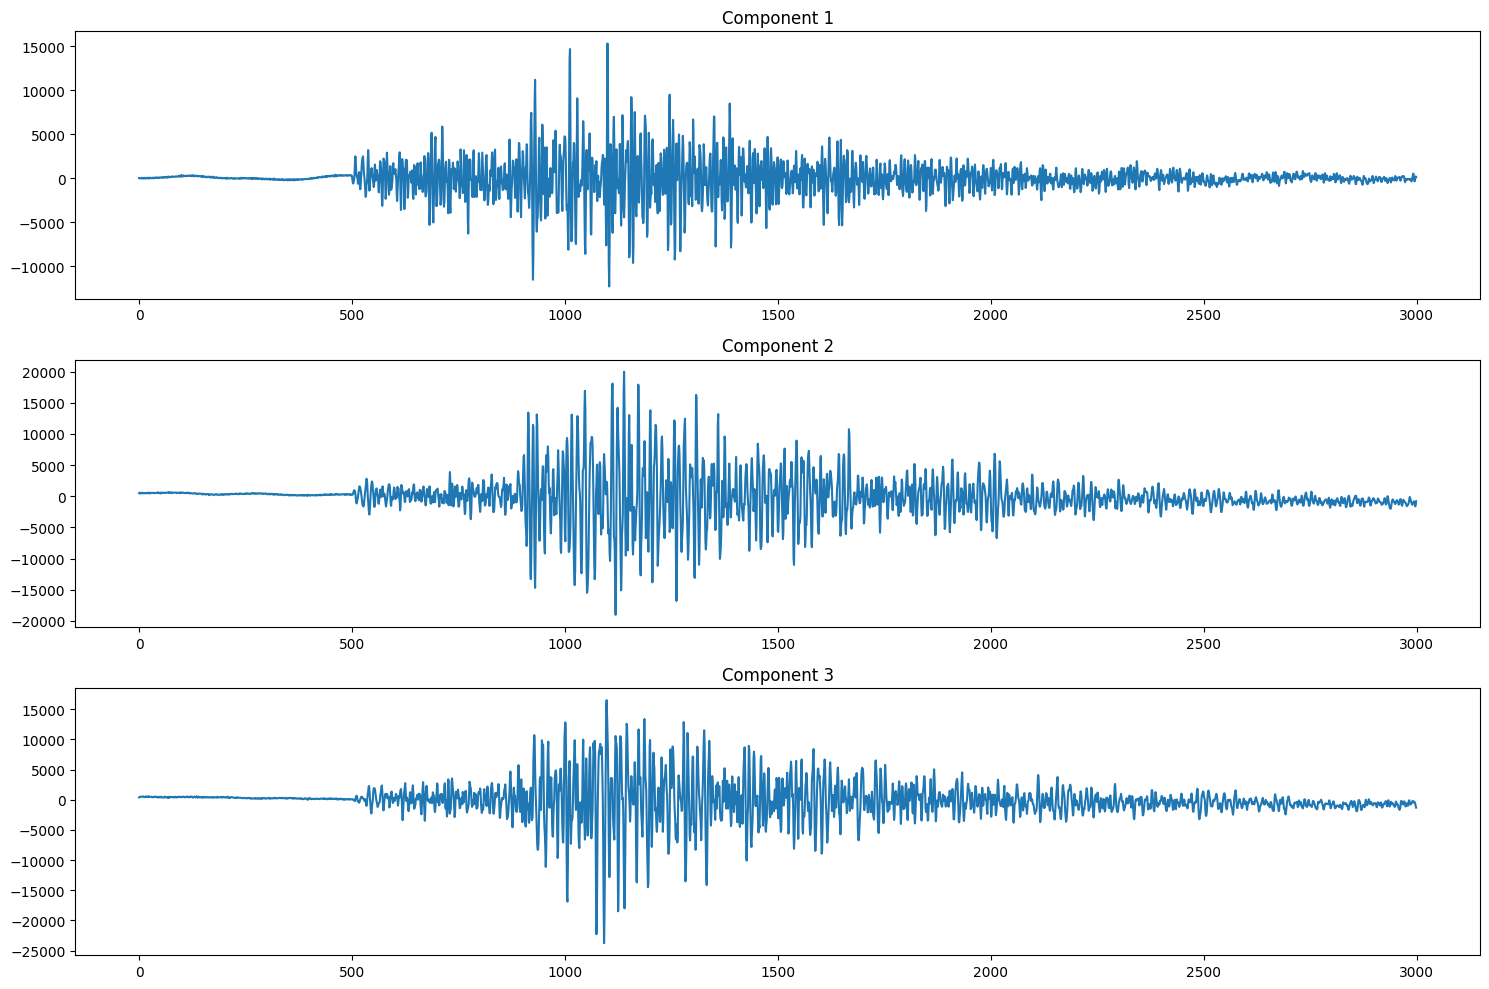

In [ ]:
# Plot a sample waveform
sample_index = 0
plt.figure(figsize=(15, 10))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(data_MO[sample_index][i])
    plt.title(f'Component {i+1}')
plt.tight_layout()
plt.show()

In [ ]:
print(filtered_metadata.columns.tolist())

['source_id', 'station_network_code', 'station_code', 'station_location_code', 'station_channels', 'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m', 'station_vs_30_mps', 'station_vs_30_detail', 'source_origin_time', 'source_latitude_deg', 'source_longitude_deg', 'source_depth_km', 'source_origin_uncertainty_s', 'source_latitude_uncertainty_deg', 'source_longitude_uncertainty_deg', 'source_depth_uncertainty_km', 'source_stderror_s', 'source_gap_deg', 'source_horizontal_uncertainty_km', 'source_magnitude', 'source_magnitude_type', 'source_mt_eval_mode', 'source_mt_status', 'source_mt_scalar_moment', 'source_mechanism_strike_dip_rake', 'source_mechanism_moment_tensor', 'path_travel_time_P_s', 'path_travel_time_S_s', 'path_residual_P_s', 'path_residual_S_s', 'path_ep_distance_km', 'path_hyp_distance_km', 'path_azimuth_deg', 'path_backazimuth_deg', 'path_weight_phase_location_P', 'path_weight_phase_location_S', 'trace_start_time', 'trace_dt_s', 'trace_npts', 'trace_eva

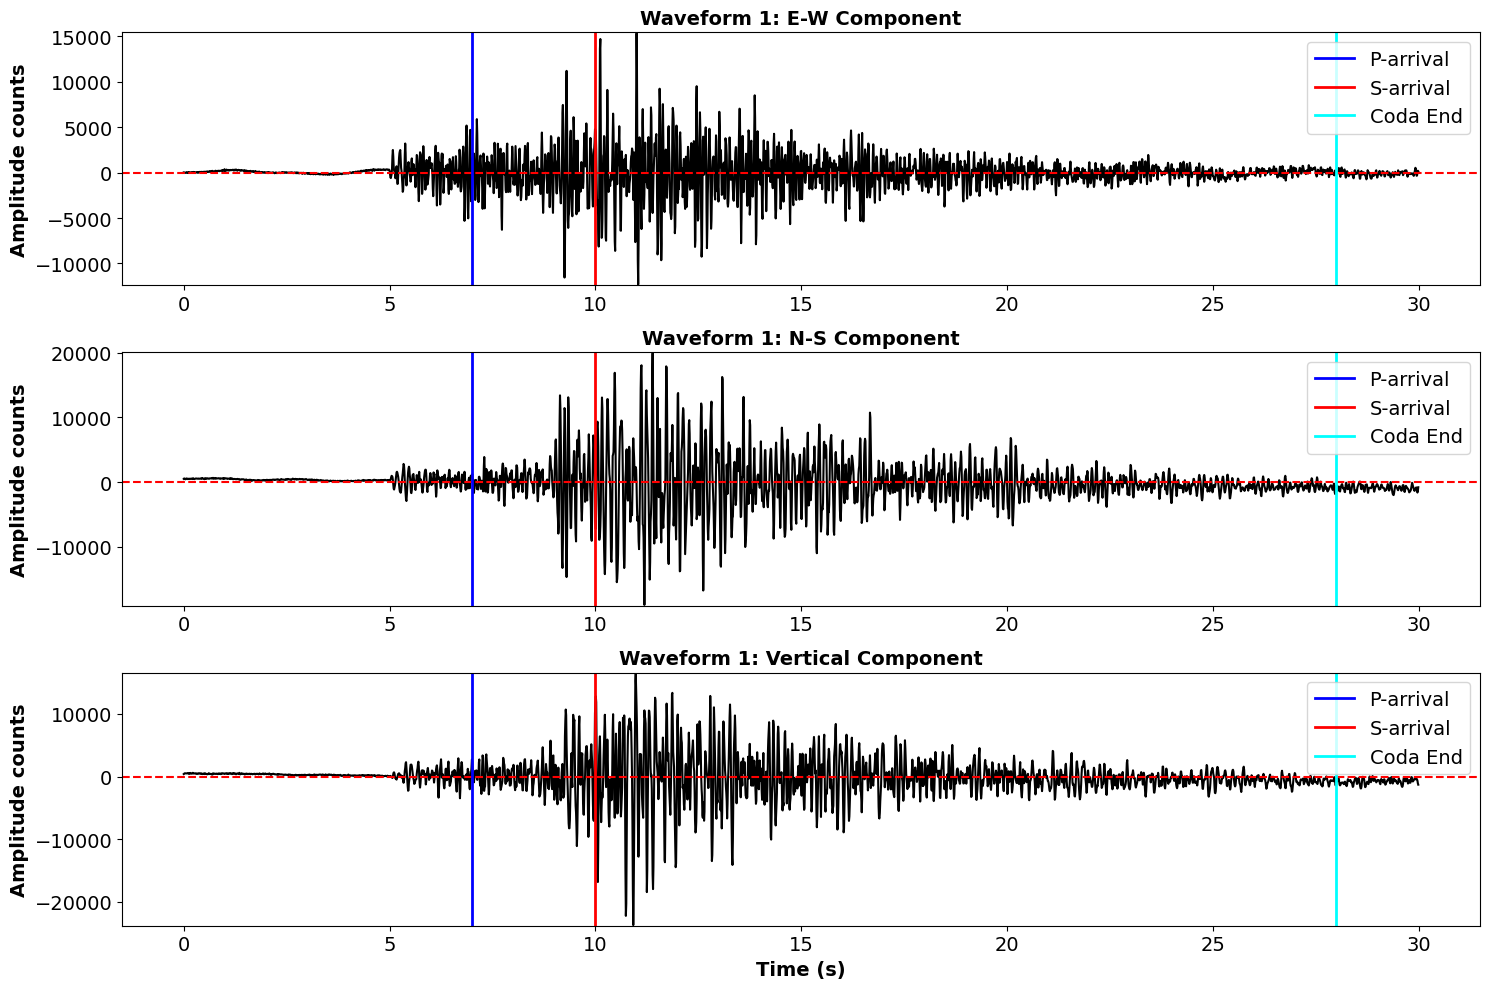

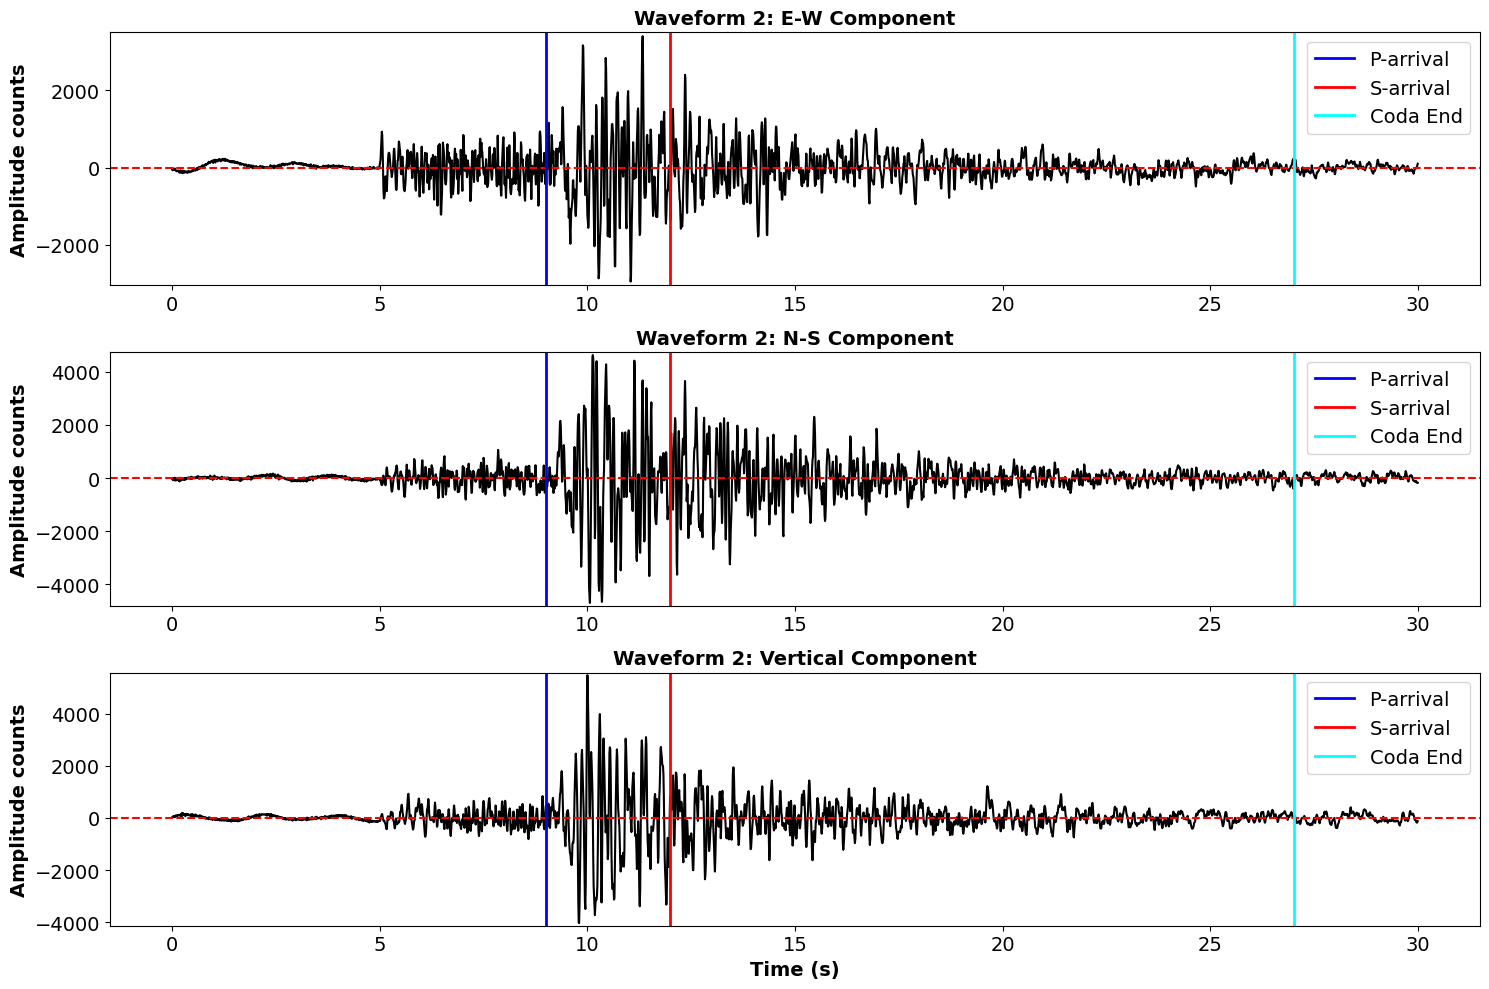

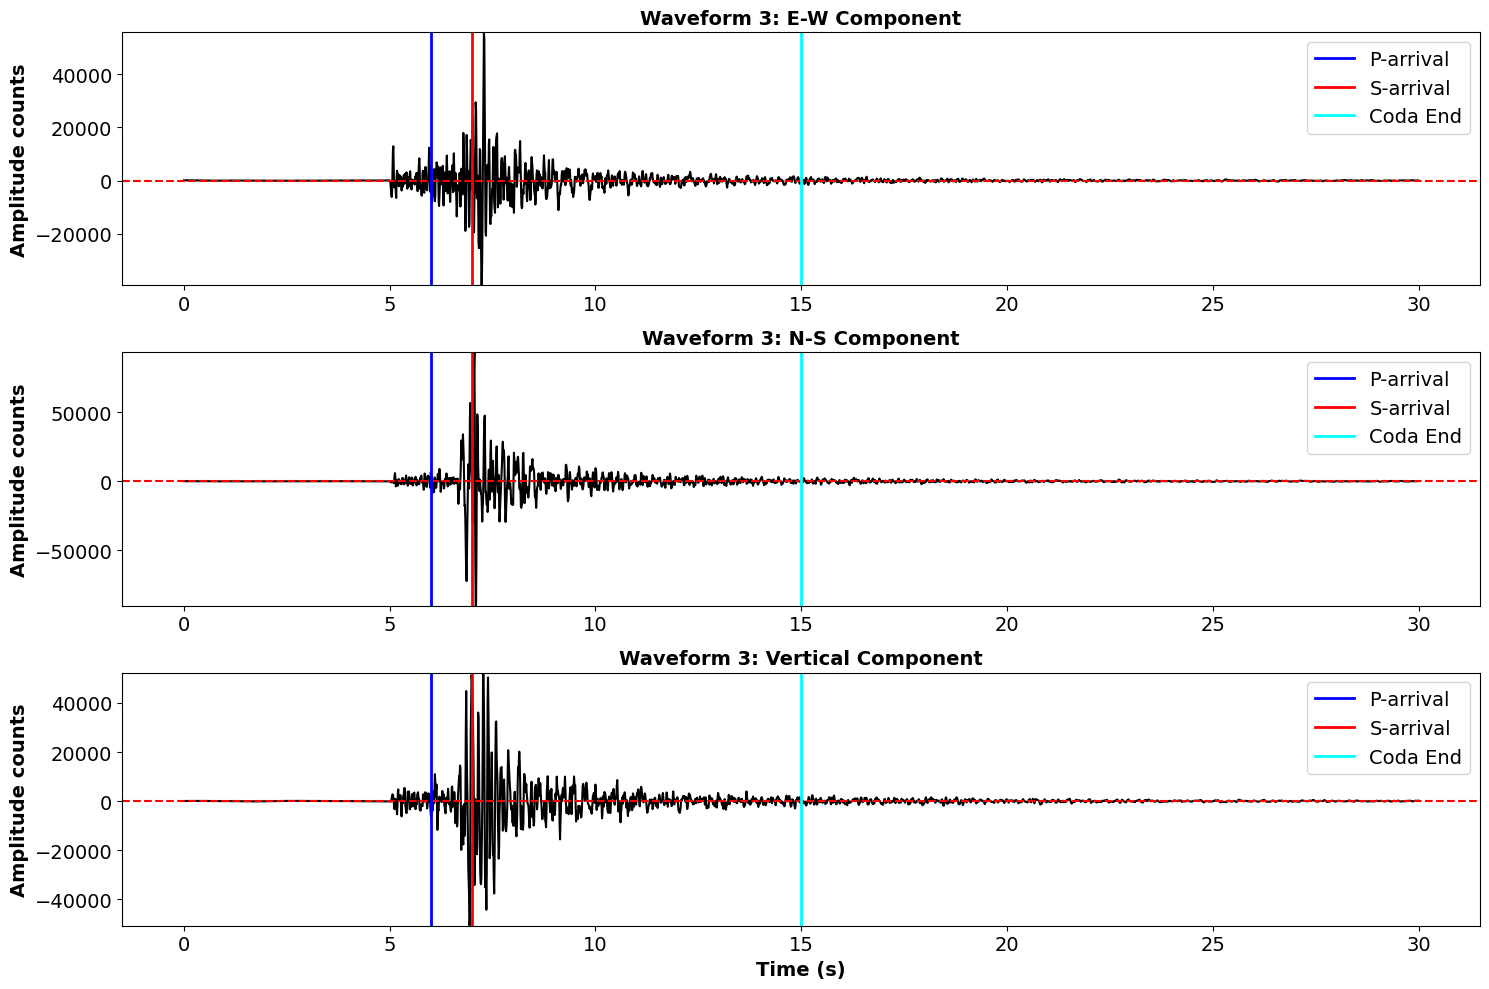

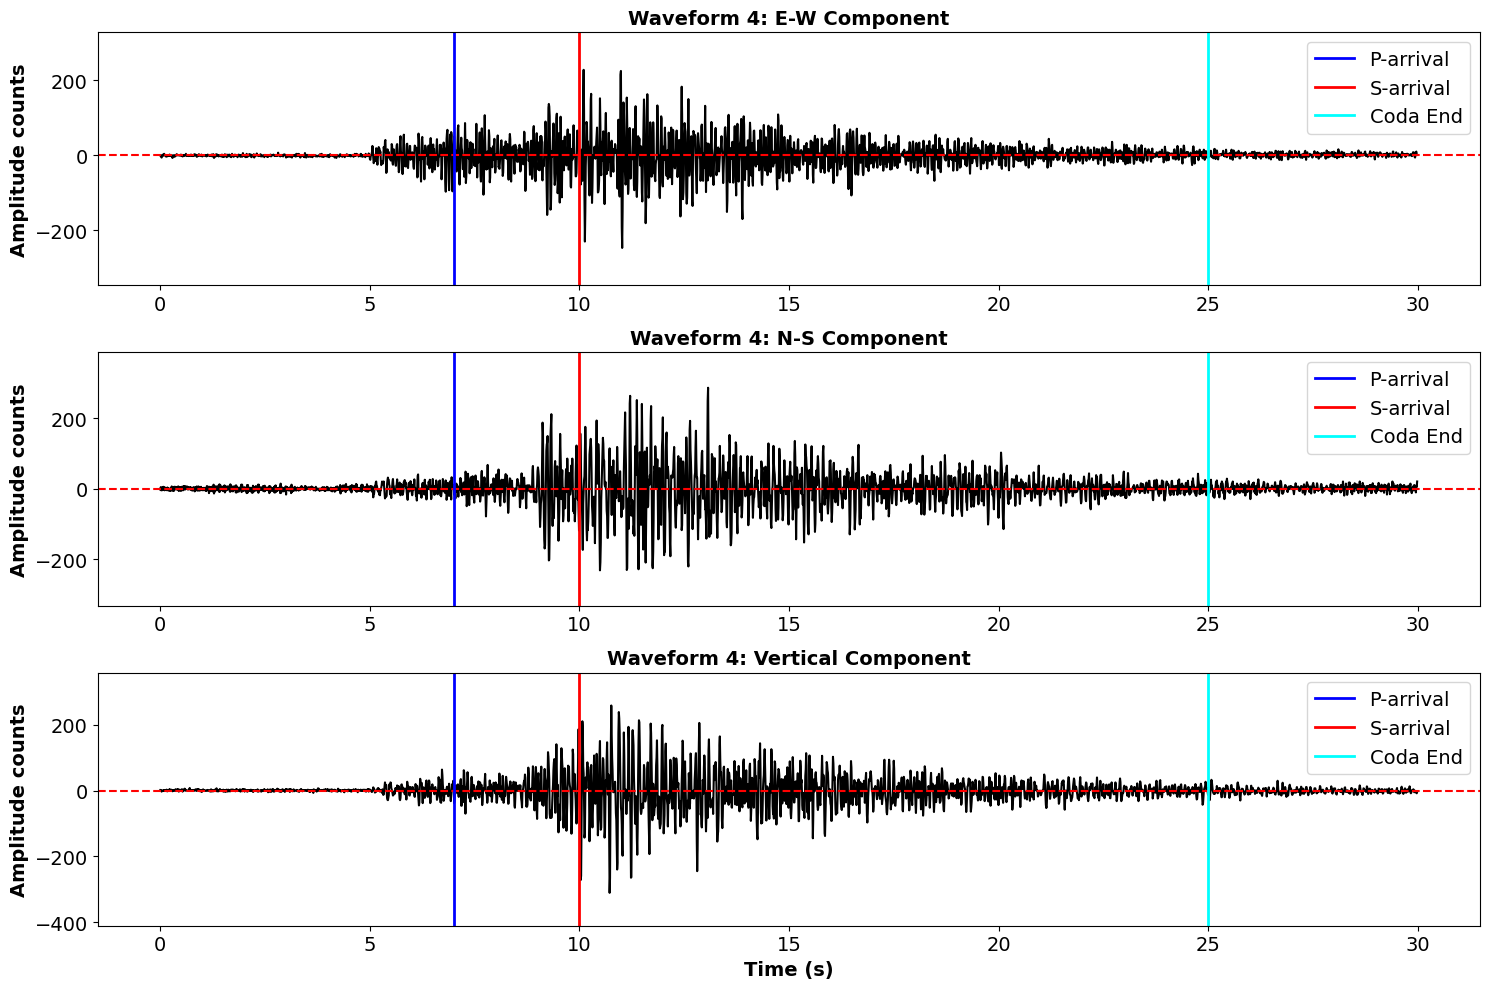

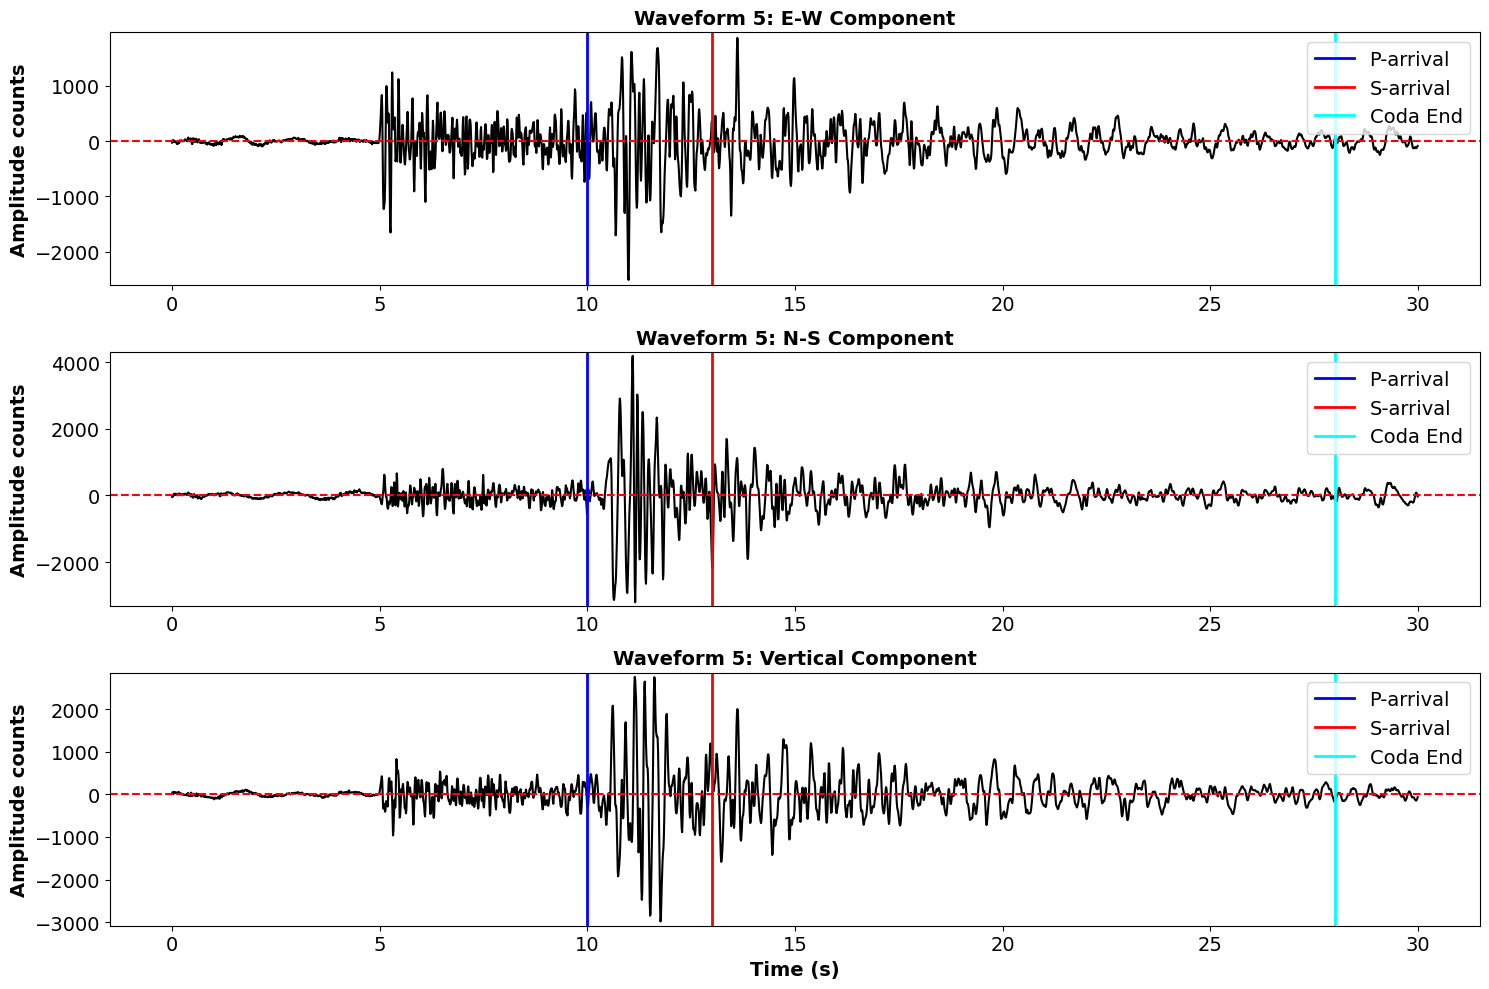

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def get_approximate_picks(index):
    # Approximate picks based on visual inspection
    approximate_picks = [
        (7, 10, 28),  # Waveform 1: (P-arrival, S-arrival, Coda end)
        (9, 12, 27),  # Waveform 2
        (6, 7, 15),   # Waveform 3
        (7, 10, 25),  # Waveform 4
        (10, 13, 28)  # Waveform 5
    ]
    return approximate_picks[index]

def plot_instance_waveform(waveform, p_arrival, s_arrival, coda_end, index, sampling_rate=100):
    fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=False) # sharex=True to share the x-axis, if set to False, each subplot will have its own x-axis
    time_axis = np.arange(0, waveform.shape[1]) / sampling_rate
    component_names = ['E-W', 'N-S', 'Vertical']

    for i in range(3):
        axs[i].plot(time_axis, waveform[i], 'k')
        axs[i].set_title(f"Waveform {index+1}: {component_names[i]} Component", fontweight='bold', fontsize=14)
        axs[i].set_ylabel('Amplitude counts', fontweight='bold', fontsize=14)
        axs[i].axhline(y=0, color='r', linestyle='--')
        axs[i].set_ylim(np.min(waveform[i])-100, np.max(waveform[i])+100)

        axs[i].axvline(x=p_arrival, color='b', linewidth=2, label='P-arrival')
        axs[i].axvline(x=s_arrival, color='r', linewidth=2, label='S-arrival')
        axs[i].axvline(x=coda_end, color='aqua', linewidth=2, label='Coda End')

        axs[i].legend(loc='upper right', fontsize=14)
        axs[i].tick_params(axis='both', which='major', labelsize=14)

    axs[2].set_xlabel('Time (s)', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

# Plot multiple sample waveforms
sample_indices = [0, 1, 2, 3, 4]

for idx in sample_indices:
    waveform = data_MO[idx].numpy()
    p_arrival, s_arrival, coda_end = get_approximate_picks(idx)

    plot_instance_waveform(waveform, p_arrival, s_arrival, coda_end, idx)